## Optimasi Model Machine Learning untuk Memprediksi Nasabah Potensial dalam Berlangganan Deposito Berjangka

# 1. Perkenalan

Nama : Harun

Batch : RMT -35

Objective : Pada Project kali ini akan Membuat model machine learning untuk memprediksi apakah nasabah akan berlangganan deposito berjangka disebuah Bank. menggunakan lima model (KNN, SVM, DecisionTree, RandomForest, CatBooster). Model terbaik akan dioptimalkan melalui hyperparameter tuning dan dideploy untuk digunakan. Evaluasi dilakukan dengan f1-score untuk memastikan keseimbangan data, mendukung bank dalam menargetkan nasabah potensial secara efisien.
Dengan prediksi yang akurat, bank dapat menargetkan nasabah yang paling potensial untuk mengikuti program deposito, sehingga meningkatkan efektivitas kampanye pemasaran.

### Problem
Bank perlu meningkatkan efektivitas kampanye pemasaran deposito berjangka dengan menargetkan nasabah yang paling potensial untuk berlangganan. Namun, tanpa prediksi yang akurat, bank mengalami kesulitan dalam menentukan nasabah yang tepat untuk ditargetkan, sehingga kampanye pemasaran menjadi kurang efisien dan biaya promosi meningkat.

### Problem statement
Diperlukan model machine learning yang mampu memprediksi apakah seorang nasabah akan berlangganan deposito berjangka berdasarkan data karakteristik nasabah dan interaksi sebelumnya dengan bank. Model ini diharapkan dapat membantu bank dalam menargetkan nasabah yang lebih potensial untuk meningkatkan efektivitas kampanye pemasaran.

### Link Deployment

https://huggingface.co/spaces/HarunYoel/HarunModel

# 2. Import Libraries

In [112]:
# untuk pengolahan data
import pandas as pd
import numpy as np

#untuk statistik
import scipy.stats as stats
from scipy.stats import chi2_contingency, pointbiserialr

#untuk vissualisasi
import matplotlib.pyplot as plt
import seaborn as sns

#untuk feature engineering
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
#untuk model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
#untuk evaluasi model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score


#untuk save model
import pickle
import joblib
import json

# 3. Data Loading

Dataset yang digunakan adalah : 
* **BANK MARKETING**
* Deskripsi dataset : Dataset ini berhubungan dengan kampanye pemasaran langsung (melalui panggilan telepon) dari sebuah institusi perbankan di Portugal. Tujuan dari klasifikasi dalam dataset ini adalah untuk memprediksi apakah nasabah akan berlangganan deposito berjangka (variabel target: y).
* Link : **`https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing`**

In [4]:
# Read data yang telah disimpan
df_ori = pd.read_csv('bank-additional-full.csv',sep=';')

In [5]:
# Duplicate data original
df = df_ori.copy()
# menampilkan data beberapa baris
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# Menampilkan informasi dasar tentang DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

- Dataset memiliki 41188 entri dan terdiri dari 21 kolom dengan bertipe data float, integer, dan object
- Tipe Data: 5 kolom berisi tipe data float64, 5 kolom berisi tipe data int64, dan 11 kolom berisi tipe data object
- semua data sudah terisi atau tidak adanya missing value yang artinya kedepannya tidak melakukan handle missing value

In [7]:
# mengecek data duplikat
df.duplicated().sum()

12

Terdapat data duplikat sebanyak 12 yang dimana kita harus menghapus data duplikat tersebut

In [8]:
# drop duplikat
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Data duplikat berhasil dihapus dan sudah menjadi 0

### Deskripsi Data Set

| **No** | **Nama Variabel**      | **Deskripsi**                                                                                                   |
|--------|------------------------|---------------------------------------------------------------------------------------------------------------|
| 1      | age                    | Umur klien bank                                                                                               |
| 2      | job                    | Jenis pekerjaan klien (admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown) |
| 3      | marital                | Status perkawinan klien (divorced, married, single, unknown)                                                   |
| 4      | education              | Tingkat pendidikan klien (basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree, unknown) |
| 5      | default                | Apakah klien memiliki kredit yang bermasalah? (no, yes, unknown)                                               |
| 6      | housing                | Apakah klien memiliki pinjaman perumahan? (no, yes, unknown)                                                   |
| 7      | loan                   | Apakah klien memiliki pinjaman pribadi? (no, yes, unknown)                                                     |
| 8      | contact                | Jenis komunikasi kontak (cellular, telephone)                                                                 |
| 9      | month                  | Bulan kontak terakhir dalam setahun (jan, feb, mar, ..., nov, dec)                                             |
| 10     | day_of_week            | Hari kontak terakhir dalam seminggu (mon, tue, wed, thu, fri)                                                  |
| 11     | duration               | Durasi kontak terakhir, dalam detik (Durasi ini sangat mempengaruhi target output, sehingga hanya digunakan untuk tujuan benchmark) |
| 12     | campaign               | Jumlah kontak yang dilakukan selama kampanye ini dan untuk klien ini                                           |
| 13     | pdays                  | Jumlah hari yang berlalu sejak klien terakhir kali dihubungi dari kampanye sebelumnya (999 berarti klien belum pernah dihubungi sebelumnya) |
| 14     | previous               | Jumlah kontak yang dilakukan sebelum kampanye ini dan untuk klien ini                                          |
| 15     | poutcome               | Hasil kampanye pemasaran sebelumnya (failure, nonexistent, success)                                            |
| 16     | emp.var.rate           | Tingkat variasi ketenagakerjaan - indikator kuartalan                                                         |
| 17     | cons.price.idx         | Indeks harga konsumen - indikator bulanan                                                                      |
| 18     | cons.conf.idx          | Indeks kepercayaan konsumen - indikator bulanan                                                                |
| 19     | euribor3m              | Tingkat euribor 3 bulan - indikator harian                                                                     |
| 20     | nr.employed            | Jumlah karyawan - indikator kuartalan                                                                          |
| 21     | y                      | Apakah klien berlangganan deposito berjangka? (yes, no)                                                       |


# 4. EDA 

Dalam bagian EDA ini akan mengeksplore terhadap dataset dengan analisa deskriptif ataupun inferencial sehingga bisa mendapati insight terhadap kondisi dataset yang ada

## 4.1 Data Target

Pada analisa kali ini akan memiliki objective yakni Prediksi apakah klien atau nasabah berlangganan deposito berjangka terhadap suatu bank sehingga diperlukan explorasi data target terlebih dahulu 

In [9]:
df['y'].value_counts()

y
no     36537
yes     4639
Name: count, dtype: int64

In [10]:
no = 36548
yes = 4640
#menghitung persentase
percet_no = (no/(no+yes))*100
percet_yes = (yes/(no+yes))*100
print(f'Percentage of Yes Class : {percet_yes} %')
print(f'Percentage of No Class : {percet_no} %')


Percentage of Yes Class : 11.265417111780131 %
Percentage of No Class : 88.73458288821988 %


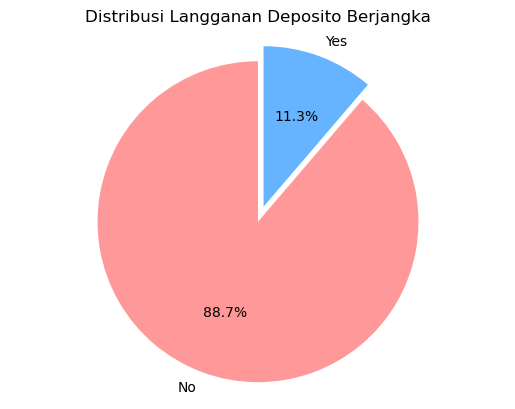

In [11]:
# Menghitung jumlah dan persentase
counts = df['y'].value_counts()
percentages = counts / len(df) * 100


# Membuat plot
labels = ['No', 'Yes']
sizes = [counts['no'], counts['yes']]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # Meledakkan bagian 'No'

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribusi Langganan Deposito Berjangka')
plt.show()

Dalam dataset ini dapat dilihat mayoritas data memiliki target no atau tidak berlangganan dengan persentase 88.7% sedangkan yang berlangganan hanya 11.3% sehingga dalam kasus objectives project ini diperlukan handling yang bisa mengatasi kasus imblanced data target

## 4.2 Pengelompokkan Tipe Data

In [12]:
#Filter untuk kategori 
cat_col = df.select_dtypes(include='object').columns.to_list()
#buat dataframe baru untuk cat col
df_cat = df[cat_col]
df_cat.head(2)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no


In [13]:
#Filter untuk numerik kontinue 
num_col = df.select_dtypes(include=['int64','float64']).columns.to_list()
#buat dataframe baru untuk cat col
df_num = df[num_col]
df_num.head(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0


## 4.3 Distibusi Data

Dalam hal ini akan mengecek persebaran data untuk setiap tipe data, dalam case data kategorikal hanya akan menampilkan chart setiap datanya karena bertipe kategori jadi tidak perlu pengecekkan Distribusi data

### 4.3.1 Data Kategori 

Dalam bagian ini akan menampilkan plot setiap data

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


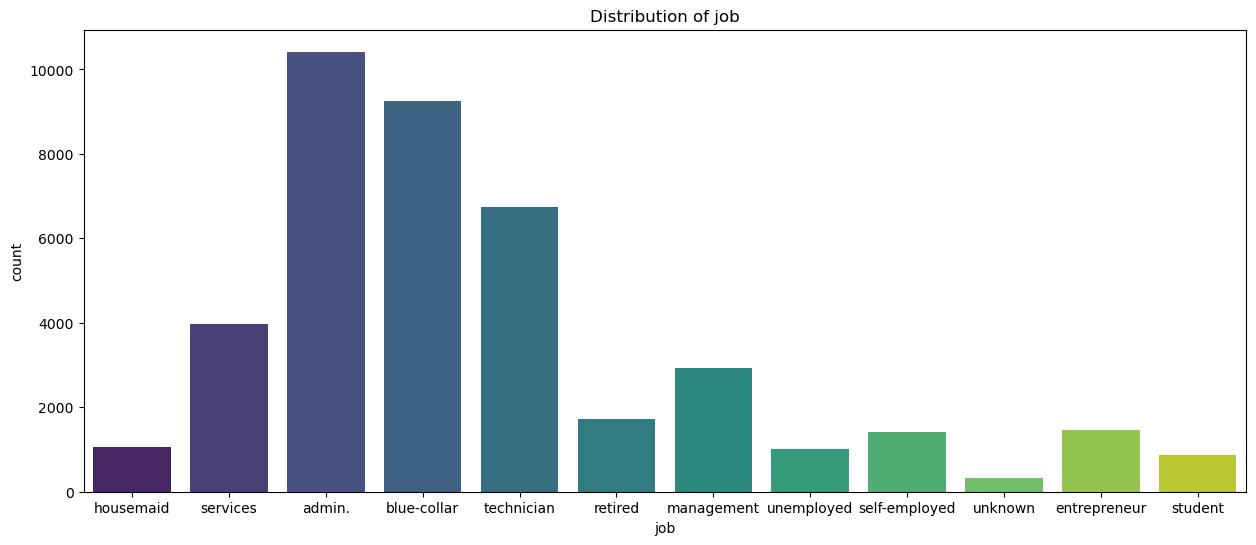

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


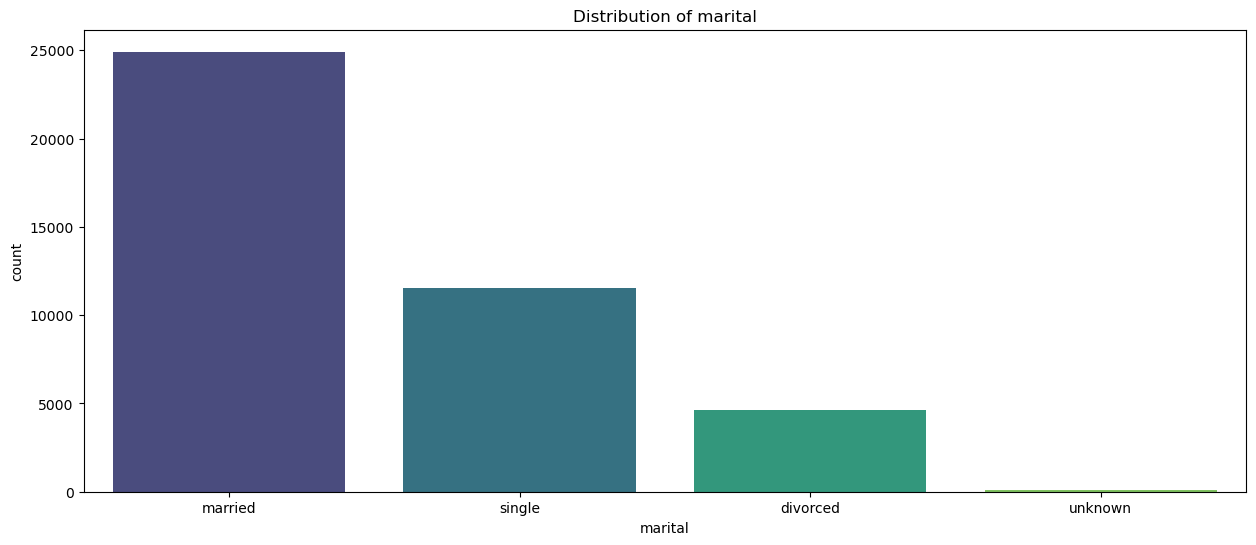

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


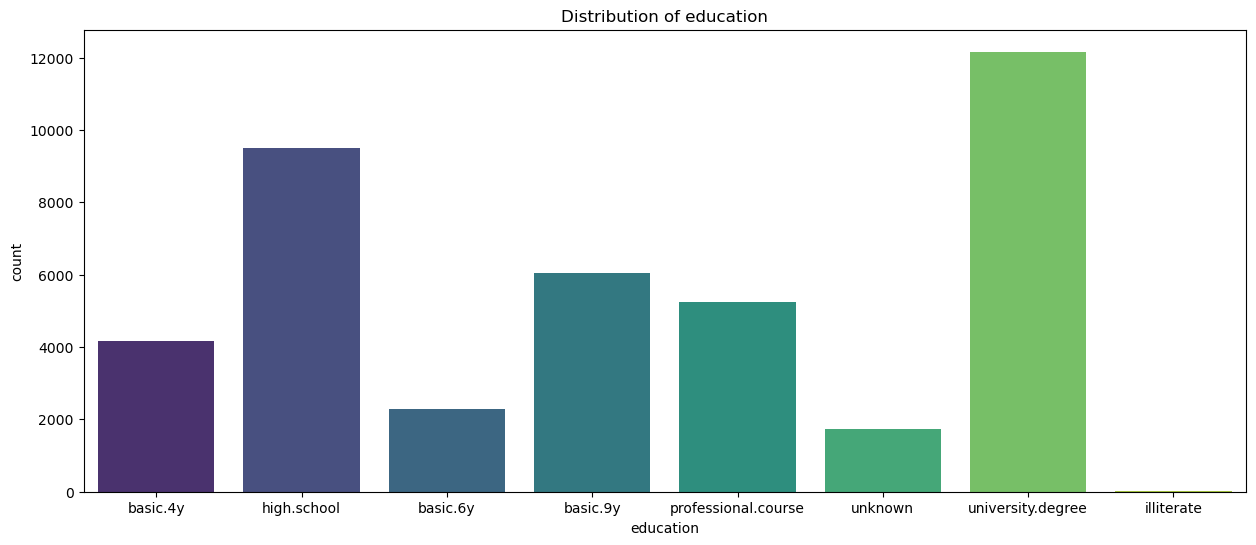

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


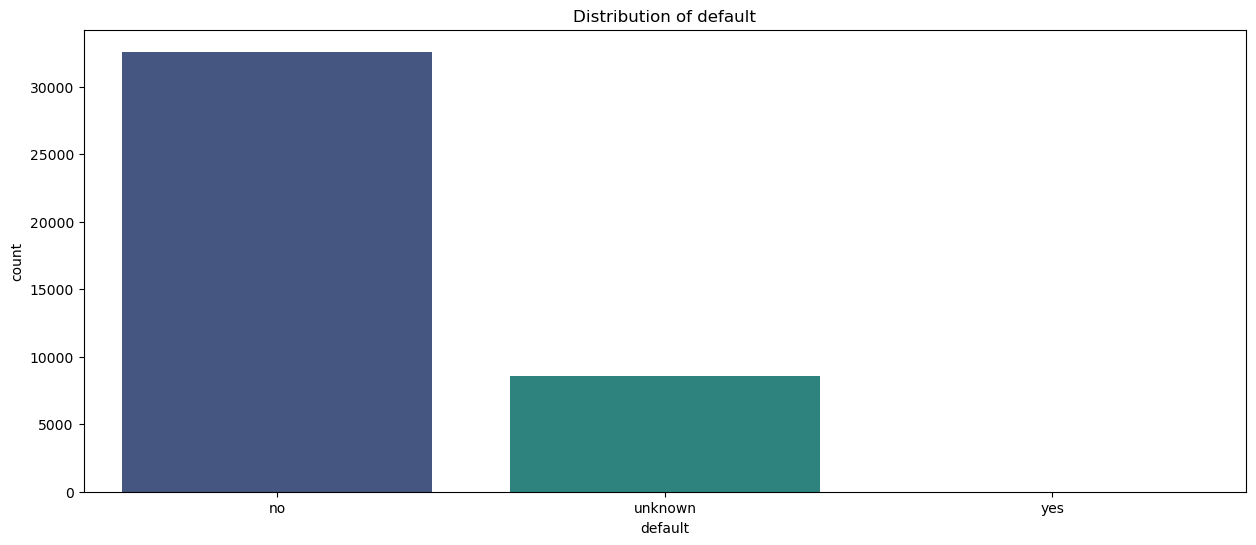

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


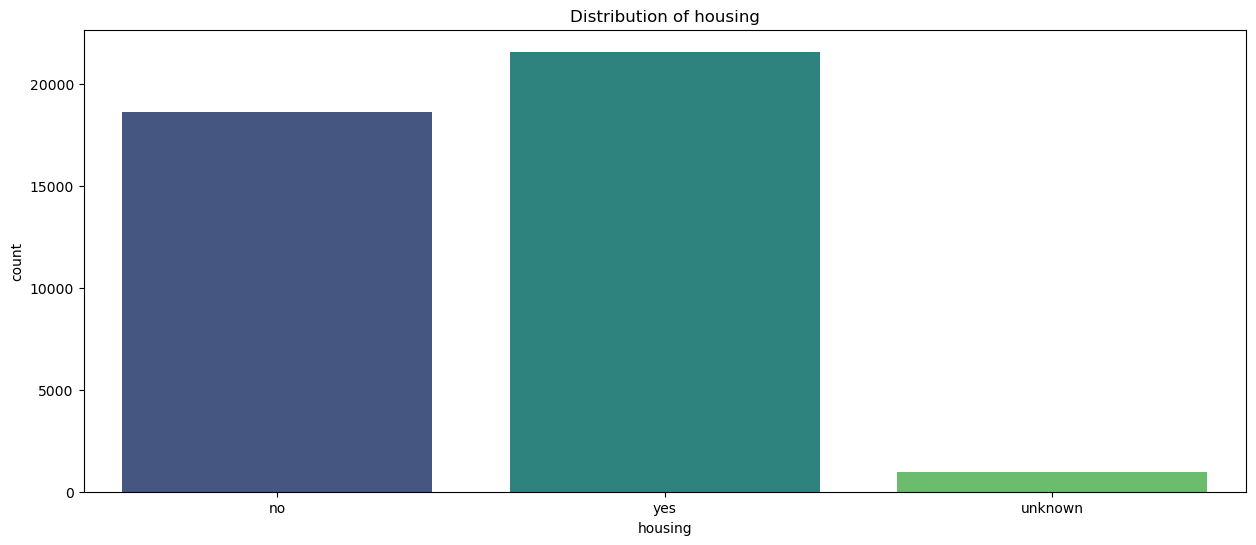

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


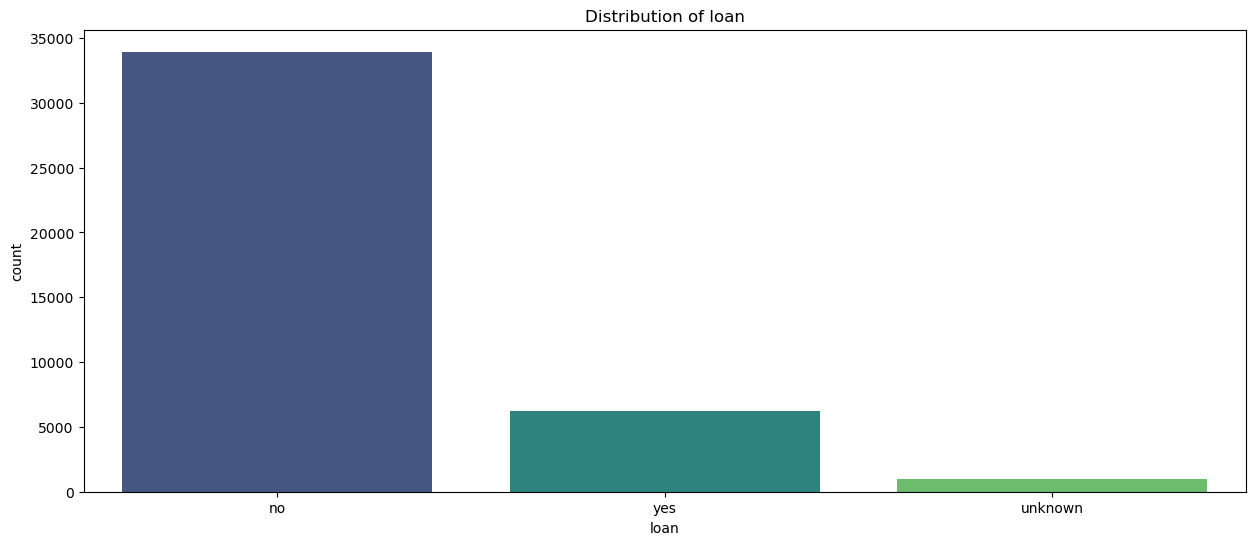

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


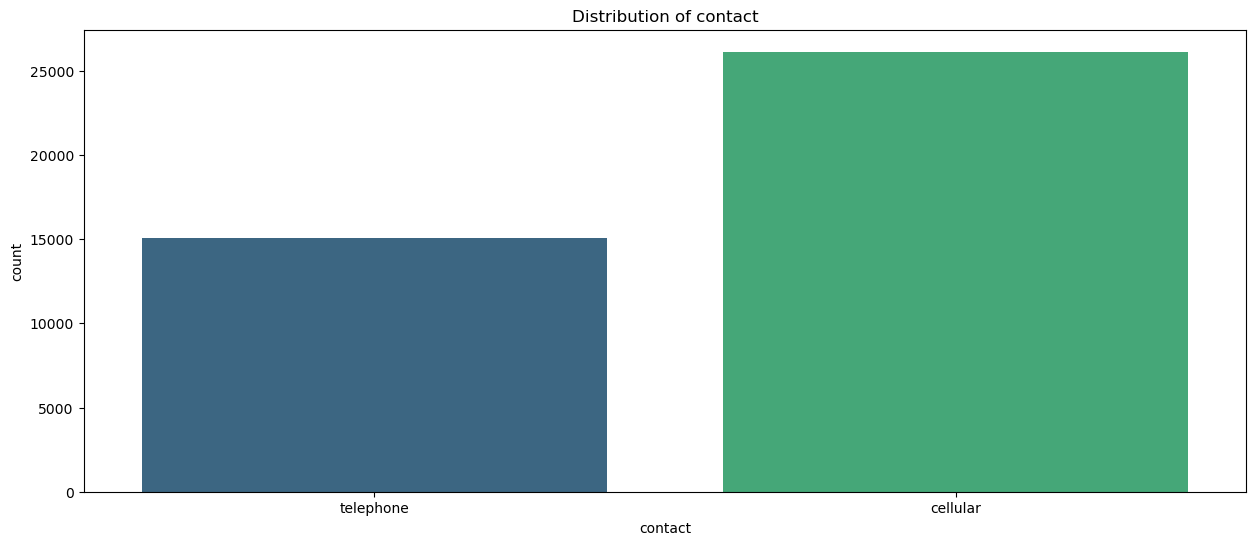

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


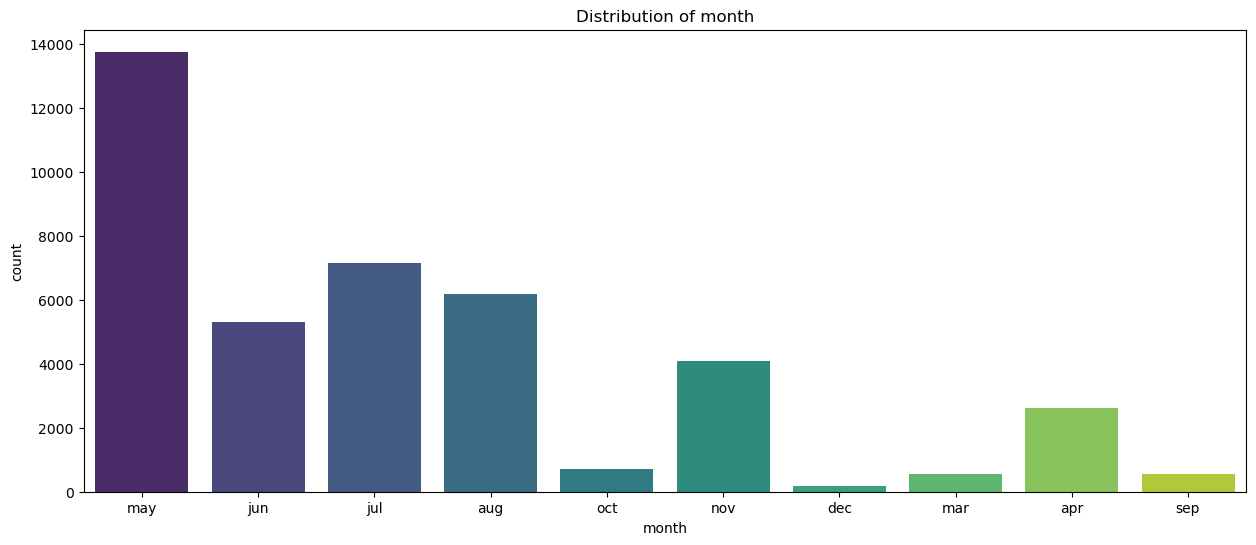

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


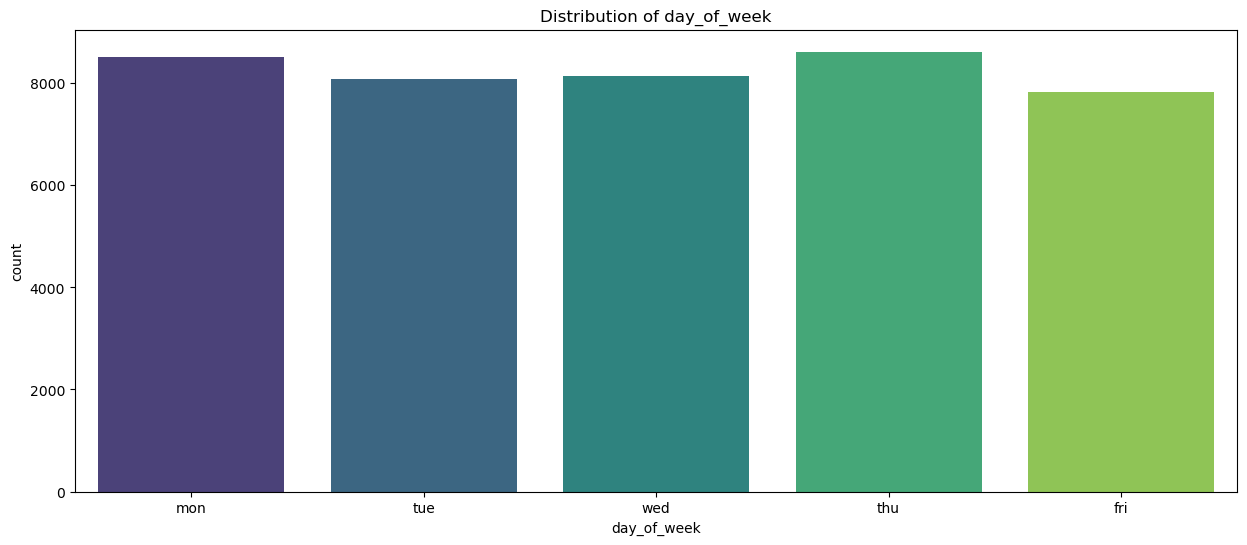

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


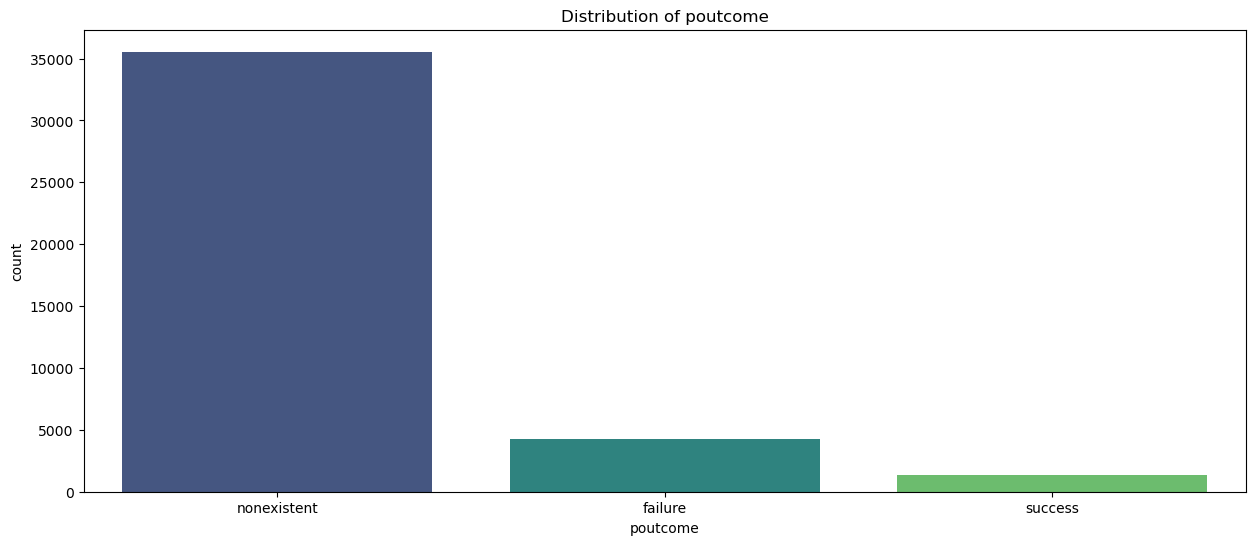

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\2362746184.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df_cat,palette='viridis')


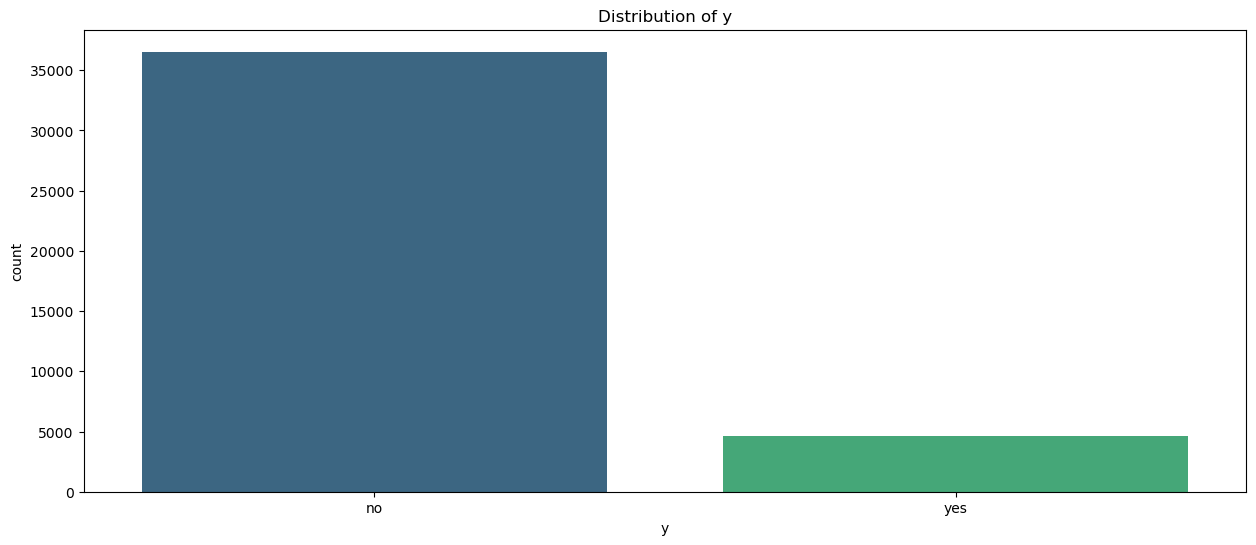

In [14]:
#looping untuk membuat visualisasi plot secara langsung terhadap seluruh fitur didalam data categori
for col in cat_col:
    #membuat besaran canva
    plt.figure(figsize=(15,6))
    #karena data kategorikal maka paling cocok digunakan dengan countplot
    sns.countplot(x=col, data=df_cat,palette='viridis')
    #definisikan title untuk setiap plot
    plt.title(f'Distribution of {col}')
    #meanmpilkan plot
    plt.show()

Dalam distribusi diatas dilihat bahawasanya terdapat beberapa fitur yang memilki values `unknown` yakni : 
* job = pekerjaan
* martial = status menikah
* education = pendidikan
* default = kepemilikan credit card
* housing = pinjaman rumah
* loan = pinjaman pribadi 

Dari hasil diatas maka dapat diindakasikan beberapa bahwasanya data data diatas bisa dikategorikan menjadi suatu missing value tetapi dirubah menjadi unknown sehingga diperlukan analisa lebih lanjut untuk bisa mengkategorikan apakah data data diatas memang suatu missing value (MAR, MCAR, MNAR) atau memang data rahasia yang memang tidak bisa dipublikasikan menurut individu tersebut,

### 4.3.2 Data Numerik Kontinue

Pada bagian ini akan mengecek distribusi dengan 3 cara dan akan dibandingkan dengan cara pertama yakni central tendecy, lalu cek skew, dan yang terakhir cek melalui visual plot

In [15]:
#pengecekkan central tendecy dengan menghitung mean dan median melalui describe
df_num.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41176.0,40.023800,10.420680,17.000,32.000,38.000,47.000,98.000
duration,41176.0,258.315815,259.305321,0.000,102.000,180.000,319.000,4918.000
campaign,41176.0,2.567879,2.770318,1.000,1.000,2.000,3.000,56.000
pdays,41176.0,962.464810,186.937102,0.000,999.000,999.000,999.000,999.000
previous,41176.0,0.173013,0.494964,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41176.0,0.081922,1.570883,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41176.0,93.575720,0.578839,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41176.0,-40.502863,4.627860,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41176.0,3.621293,1.734437,0.634,1.344,4.857,4.961,5.045
nr.employed,41176.0,5167.034870,72.251364,4963.600,5099.100,5191.000,5228.100,5228.100


Dalam hasil diatas dapat dilihat sebagai berikut : 
1. Skew Positif ( Mean Lebih besar dari pada Median ): 
    * Age
    * Duration
    * campaign
    * previous
    * cons.conf.idx
2. Skew Negatif ( Mean Lebih kecil dari pada Median ): 
    * pdays
    * emp.var.rate
    * cons.price.idx
    * euribor3m
    * employed

In [16]:
#Pengecekan melalui uji skew
#membuat var untuk list
listItem = []
#mengecek keseluruhan nilai dengan looping
for col in df_num:
    #menambahkan ke var listItem untuk nilai skew
    listItem.append([col, df_num[col].skew()])
#membuat dataframe untuk skew
skew_df = pd.DataFrame(columns=['Feature','Skewness'], data=listItem)
skew_df

,Feature,Skewness
0,age,0.784560
1,duration,3.262808
2,campaign,4.762044
3,pdays,-4.921386
4,previous,3.831396
5,emp.var.rate,-0.724061
6,cons.price.idx,-0.230853
7,cons.conf.idx,0.302876
8,euribor3m,-0.709194
9,nr.employed,-1.044317


Setelah dicek dengan pendekatan nilai skew maka ada beberapa yang berbeda dibandingkan dengan Central Tendency yakni pada fitur `cons.conf.idx` dan `cons.price.idx` berdistribusi normal bukan skew karena nilainya masih diantara -0,5 s.d 0.5 

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


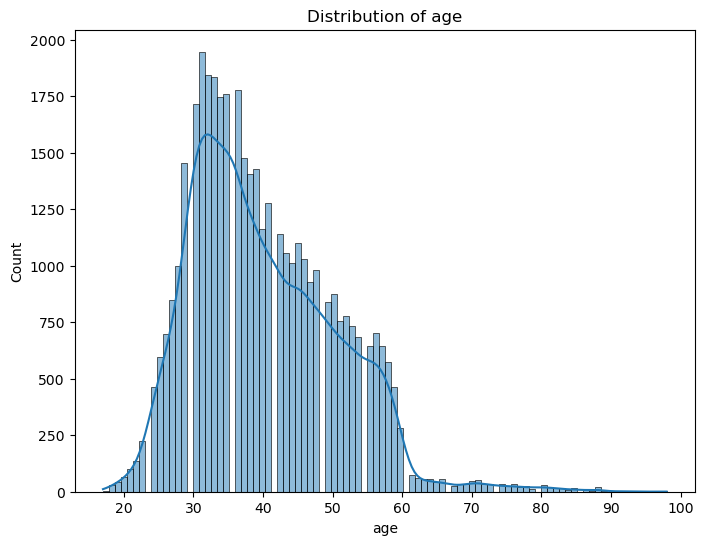

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


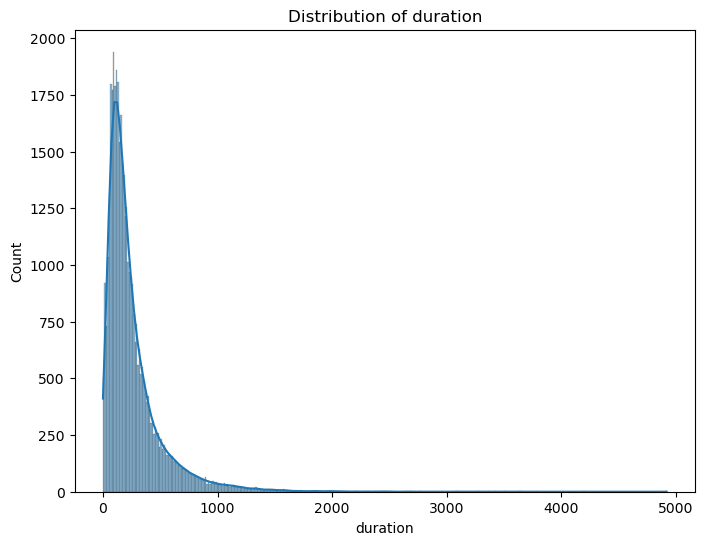

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


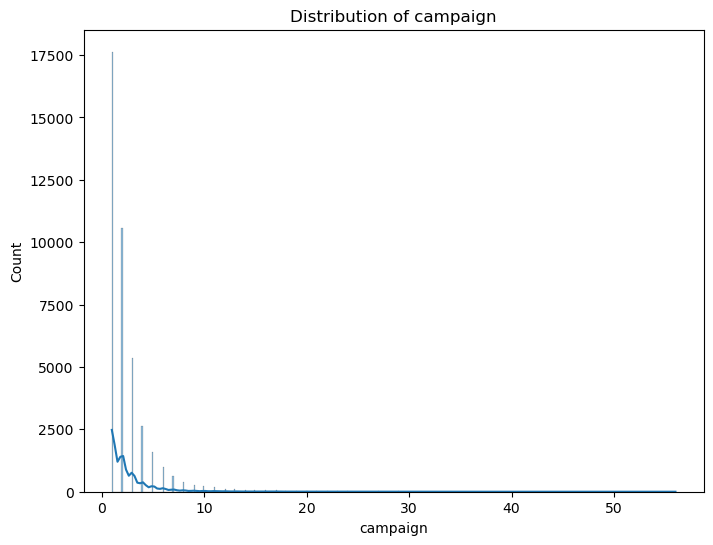

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


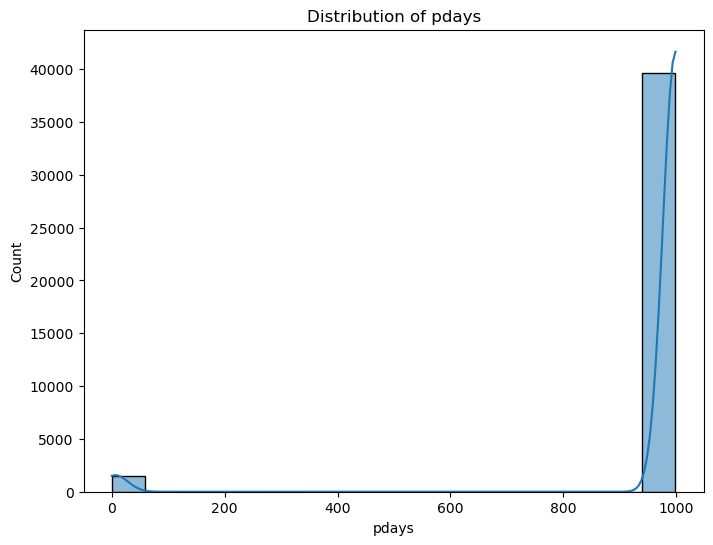

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


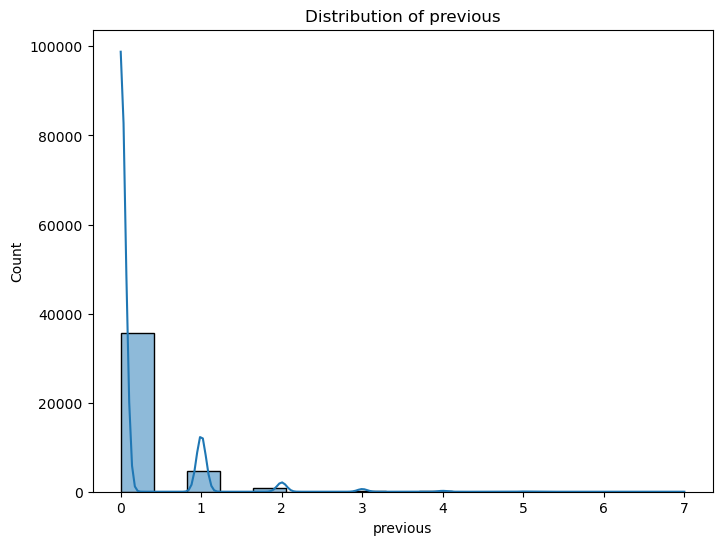

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


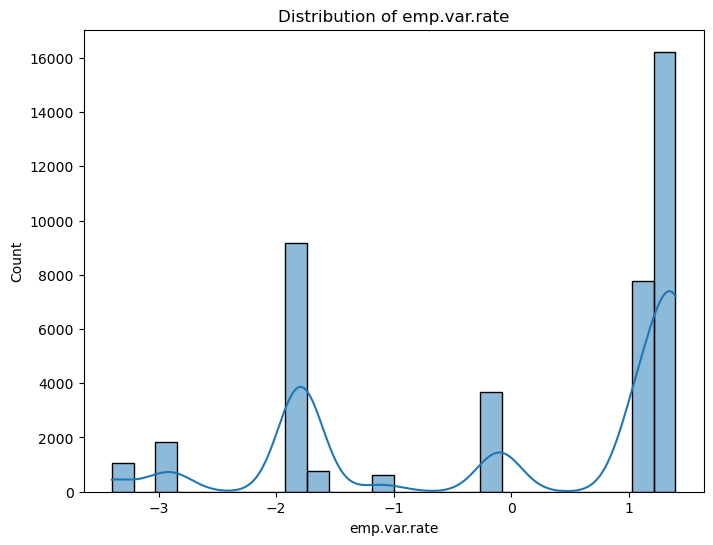

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


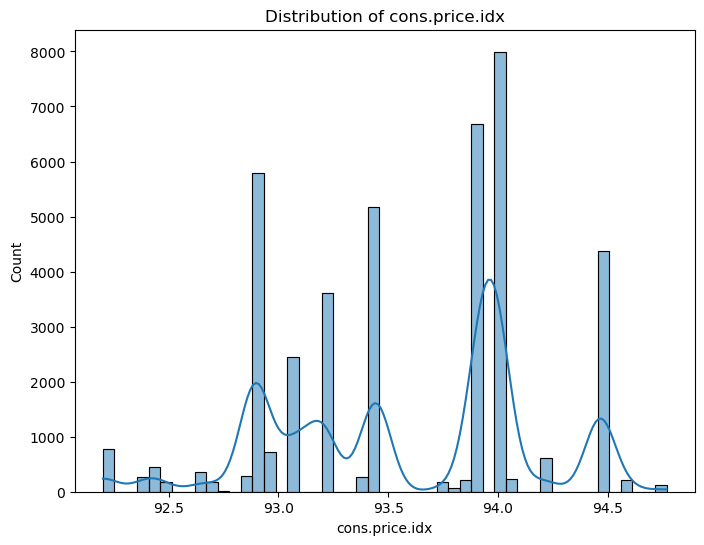

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


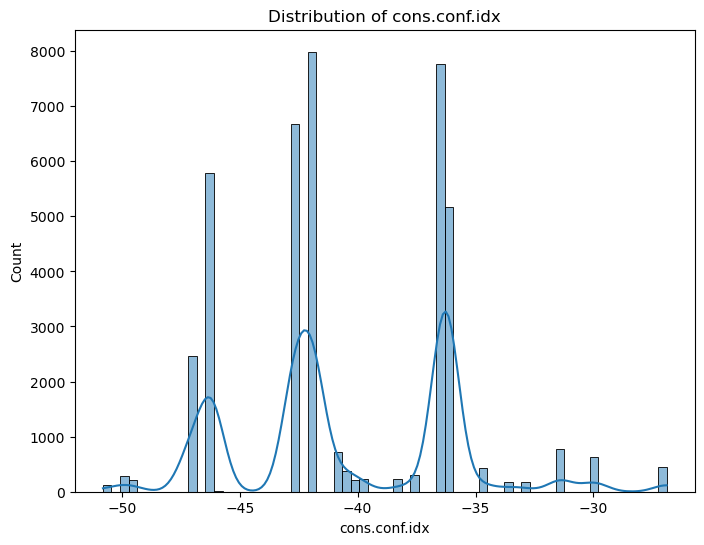

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


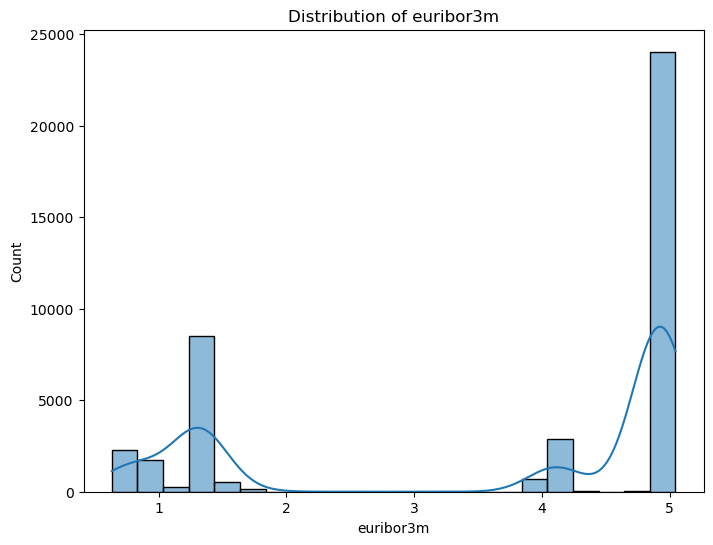

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\1844180722.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')


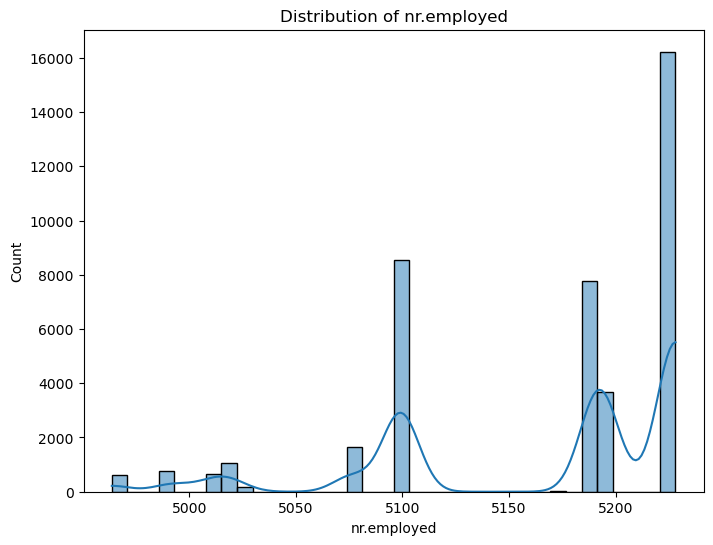

In [17]:
#Pengecekan distribusi berdasarkan visualisasi plot
#membuat loopong untuk setiap feature di dataset numerik
for col in df_num.columns:
  #setting besaran canva
  plt.figure(figsize=(8, 6))
  #menggunakan histogram karena bersifat numerik sehingga cocok untuk dijadikan visualisasi
  sns.histplot(x=col, data=df_num,kde = True ,palette='viridis')
  plt.title(f'Distribution of {col}')
  plt.show()

Apabila dilihat dengan menggunakan plot sangat sulit digambarkan bagaiman kondisi distrubusi terhadap dataset ini sehingga untuk penentuan distribusi data lebih baik tetap menggunakan pengecekan melalui tes skewness.

In [18]:
#Save list hasil cek skew untuk pengecekkan outliers dan handlingnya
listSkew = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'euribor3m', 'nr.employed']
listNorm = ['cons.price.idx','cons.conf.idx']

#buat dataframe yang berdasarkan distribusinya
df_num_norm = df_num[listNorm]
df_num_skew = df_num[listSkew]

## 4.4 Pengecekkan Outliers

Pada bagian ini akan mengecek outliers terhadap data numerik saja dan juga digolongkan sesuai dengan distribusinya

### 4.4.1 Distribusi Skew

Pengecekkan menggunakan metode Tukey's Rule karena memilki persebaran skew

In [19]:
#membuat variable untuk menampung data
listItem = []

for col in df_num_skew:
    #menggunakan metode Tukey's Rule Karena Distribusi Skew
    q1 = df_num_skew[col].quantile(0.25)
    q3 = df_num_skew[col].quantile(0.75)
    iqr = q3-q1
    up_bound = q3 + 1.5*iqr
    low_bound = q1 - 1.5*iqr
    outliers = df_num_skew[col][(df_num_skew[col]>up_bound) | (df_num_skew[col]<low_bound)]
    no_outliers = df_num_skew[col][(df_num_skew[col]<=up_bound) & (df_num_skew[col]>=low_bound)]
    percentage = len(outliers)*100/len(df_num_skew[col])
    listItem.append([col, percentage])
#convert to dataframe
outliers_df_skew = pd.DataFrame(columns=['Feature','Outliers'], data=listItem)
outliers_df_skew

,Feature,Outliers
0,age,1.136584
1,duration,7.195939
2,campaign,5.843210
3,pdays,3.679328
4,previous,13.660870
5,emp.var.rate,0.000000
6,euribor3m,0.000000
7,nr.employed,0.000000


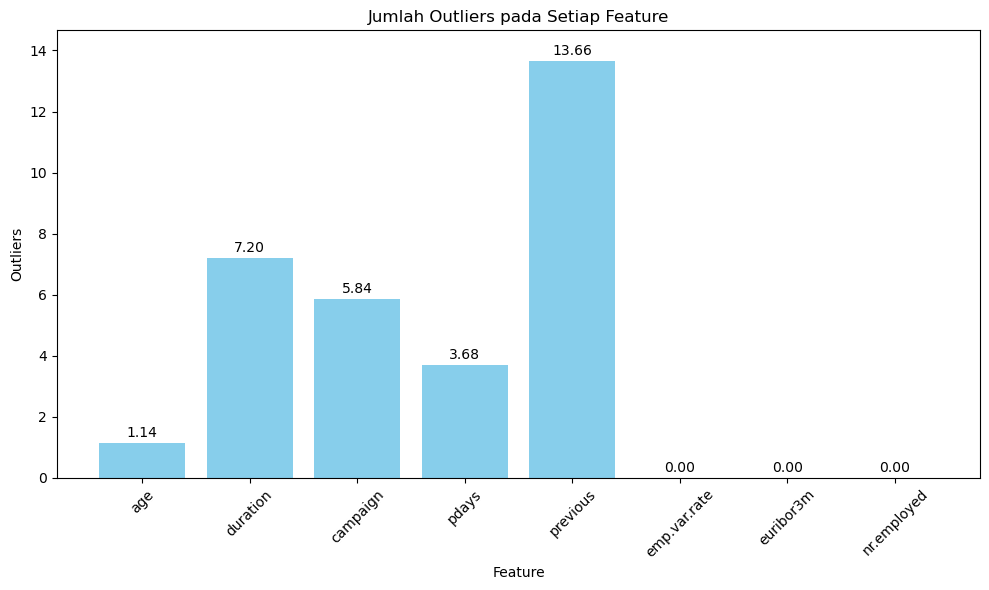

In [20]:
# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(outliers_df_skew['Feature'], outliers_df_skew['Outliers'], color='skyblue')

plt.xlabel('Feature')
plt.ylabel('Outliers')
plt.title('Jumlah Outliers pada Setiap Feature')
plt.xticks(rotation=45)
plt.ylim(0, max(outliers_df_skew['Outliers']) + 1)  # Memberi sedikit ruang di atas bar tertinggi

# Menampilkan nilai outliers di atas setiap bar
for i, v in enumerate(outliers_df_skew['Outliers']):
    plt.text(i, v + 0.2, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

Dari hasil diatas dapat dilihat bahwasanya outliers yang dimilkii tergolong besar apabila menggunakan metode Tukey's Rule

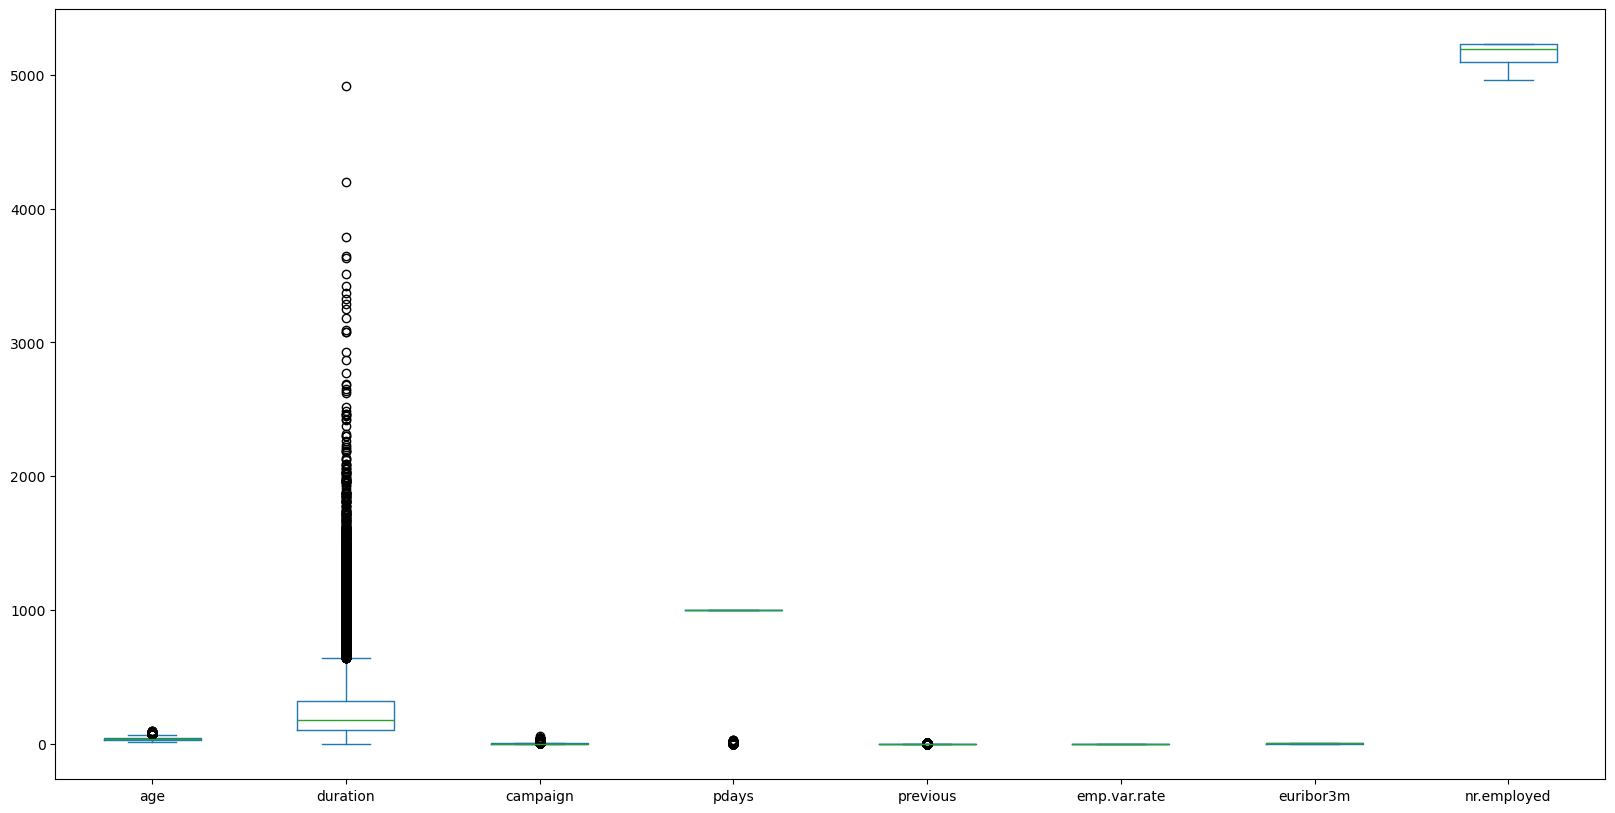

In [21]:
#membuat boxplot untuk keselurhan data skew 
df_num_skew.plot(kind='box',figsize=(20,10))
plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\3820581583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_skew[col], palette='pink')


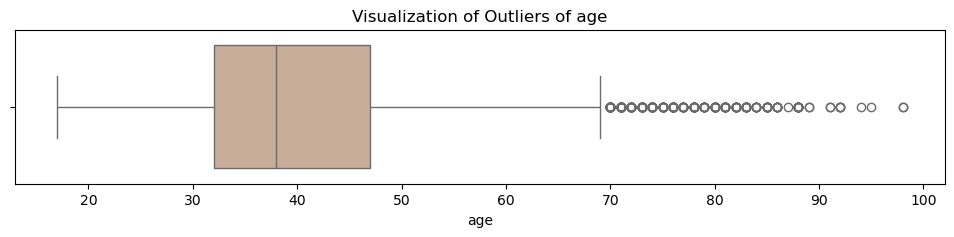

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\3820581583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_skew[col], palette='pink')


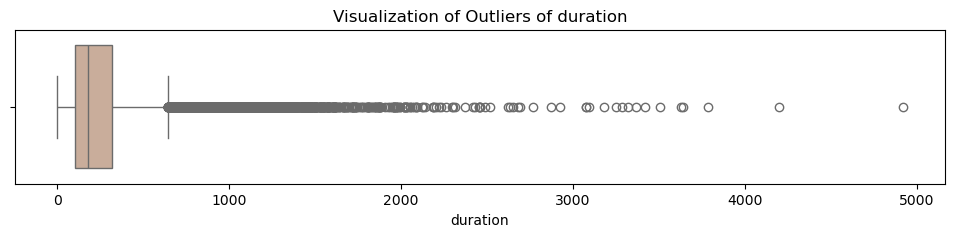

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\3820581583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_skew[col], palette='pink')


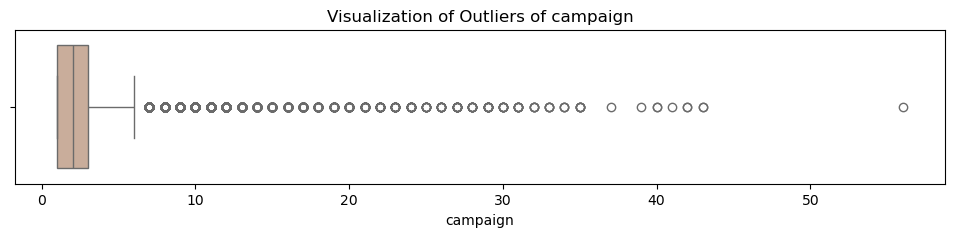

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\3820581583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_skew[col], palette='pink')


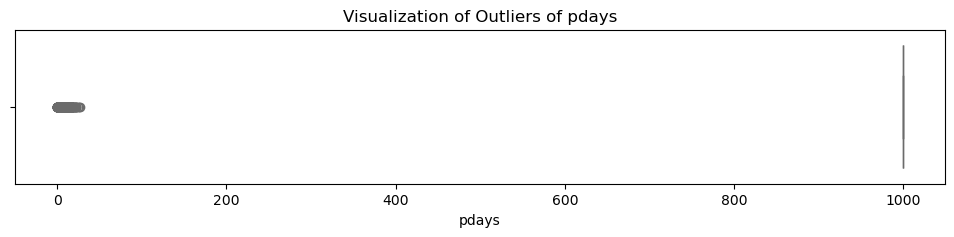

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\3820581583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_skew[col], palette='pink')


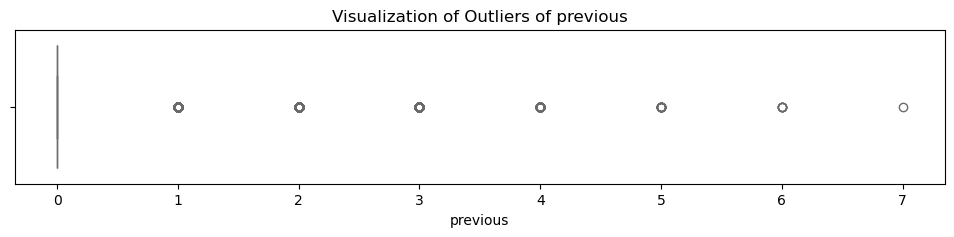

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\3820581583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_skew[col], palette='pink')


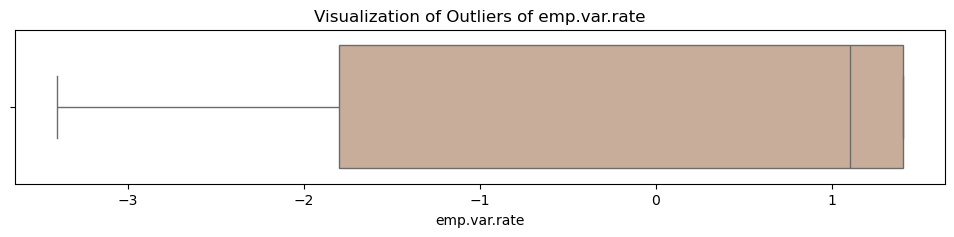

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\3820581583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_skew[col], palette='pink')


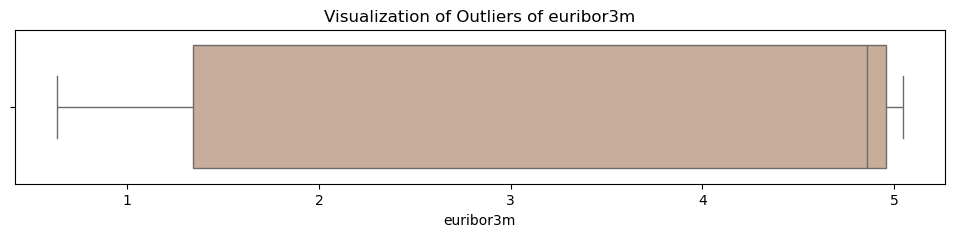

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\3820581583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_skew[col], palette='pink')


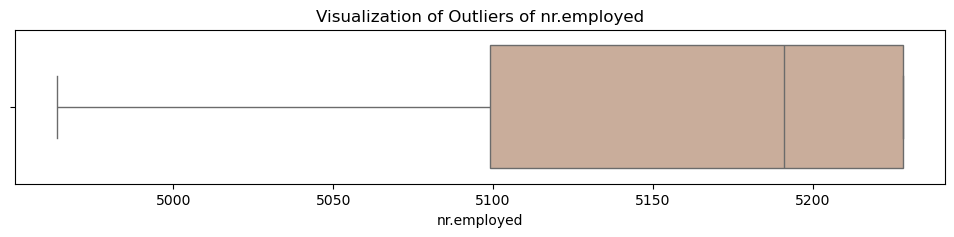

In [22]:
for col in df_num_skew:
    #membuat perulangan unttuk setiap data didalam dataset
    plt.figure(figsize=(12,2))
    sns.boxplot(x=df_num_skew[col], palette='pink')
    plt.title(f'Visualization of Outliers of {col}')
    plt.show()

Dapat dilihat terdapat anomali untuk feature pdays dan previous yakni : 
* previous dia memiliki outliers yang menumpuk dimana bisa dikatakan yang memilki value 0 dapat dilihat pada distribusi data
* previous dia memilki outliers yang konsisten setiap titik dikarenakan variance pada feature ini cenderung kecil tetapi value yang dimilki kecil dan cenderung menumpuk disalah satu fitur saja sehingga memilki pola seperti itu

### 4.2.2 Distribusi Normal

Dalam bagian ini akan mengecek menggunakan distribusi normal dengan metode Z-Score

In [23]:
#membuat variable untuk menampung data
listItem = []

for col in df_num_norm:
    #menggunakan metode Z-Score karena distribusi Normal
    #menggunakan rumus Z-Score
    avg = df_num_norm[col].mean()
    std = df_num_norm[col].std()
    up_bound = avg + 3*std
    low_bound = avg - 3*std
    outlier = df_num_norm[col][(df_num_norm[col]<low_bound) | (df_num_norm[col]>up_bound)] #deklarasi untuk menampung data outlier
    no_outlier = df_num_norm[col][(df_num_norm[col]>=low_bound) & (df_num_norm[col]<=up_bound)] #deklarasi untuk menampung data bersih
    percentage = len(outliers)*100/len(df_num_norm[col])
    listItem.append([col, percentage])
#convert to dataframe
outliers_df_norm = pd.DataFrame(columns=['Feature','Outliers'], data=listItem)
outliers_df_norm

,Feature,Outliers
0,cons.price.idx,0.0
1,cons.conf.idx,0.0


C:\Users\dell\AppData\Local\Temp\ipykernel_8532\274084416.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_norm[col], palette='pink')


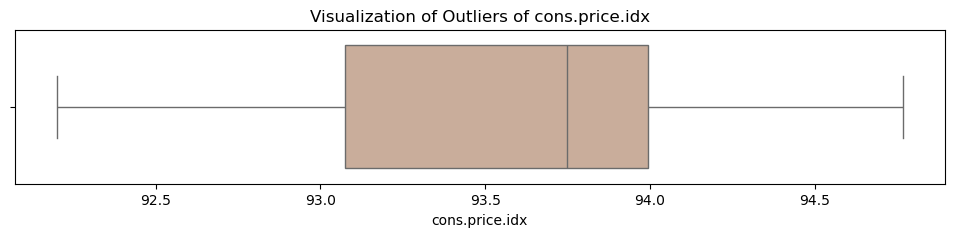

C:\Users\dell\AppData\Local\Temp\ipykernel_8532\274084416.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_num_norm[col], palette='pink')


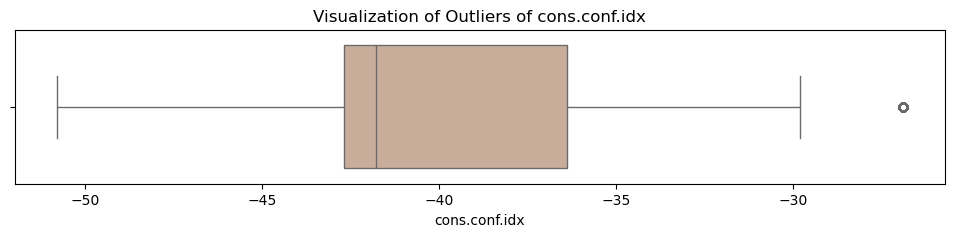

In [24]:
for col in df_num_norm:
    #membuat perulangan unttuk setiap data didalam dataset
    plt.figure(figsize=(12,2))
    sns.boxplot(x=df_num_norm[col], palette='pink')
    plt.title(f'Visualization of Outliers of {col}')
    plt.show()

Dalam data normal dapat dilihat bahwaanya tidak ada ourliersnya

## 4.5 Korelasi Fitur 

Untuk bagian ini akan mengecek korelasi antar fitur

#### 4.5.1.1 Korelasi Antar Fitur Numerik

In [25]:
#menggunakan spearman karena kebnyakn berdistribusi skew
corr_feature = df_num.corr('spearman')
corr_feature

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.002017,0.005754,-0.001065,-0.012639,0.045064,0.044871,0.114313,0.054460,0.044845
duration,-0.002017,1.000000,-0.081101,-0.083056,0.042360,-0.069110,0.002872,-0.008637,-0.078221,-0.095135
campaign,0.005754,-0.081101,1.000000,0.055551,-0.087491,0.156419,0.096475,-0.001403,0.140634,0.144311
pdays,-0.001065,-0.083056,0.055551,1.000000,-0.509580,0.227741,0.056785,-0.077283,0.278530,0.290714
previous,-0.012639,0.042360,-0.087491,-0.509580,1.000000,-0.435385,-0.282791,-0.115981,-0.454800,-0.438791
emp.var.rate,0.045064,-0.069110,0.156419,0.227741,-0.435385,1.000000,0.664881,0.224840,0.939915,0.944687
cons.price.idx,0.044871,0.002872,0.096475,0.056785,-0.282791,0.664881,1.000000,0.245771,0.490945,0.464699
cons.conf.idx,0.114313,-0.008637,-0.001403,-0.077283,-0.115981,0.224840,0.245771,1.000000,0.236790,0.132812
euribor3m,0.054460,-0.078221,0.140634,0.278530,-0.454800,0.939915,0.490945,0.236790,1.000000,0.928853
nr.employed,0.044845,-0.095135,0.144311,0.290714,-0.438791,0.944687,0.464699,0.132812,0.928853,1.000000


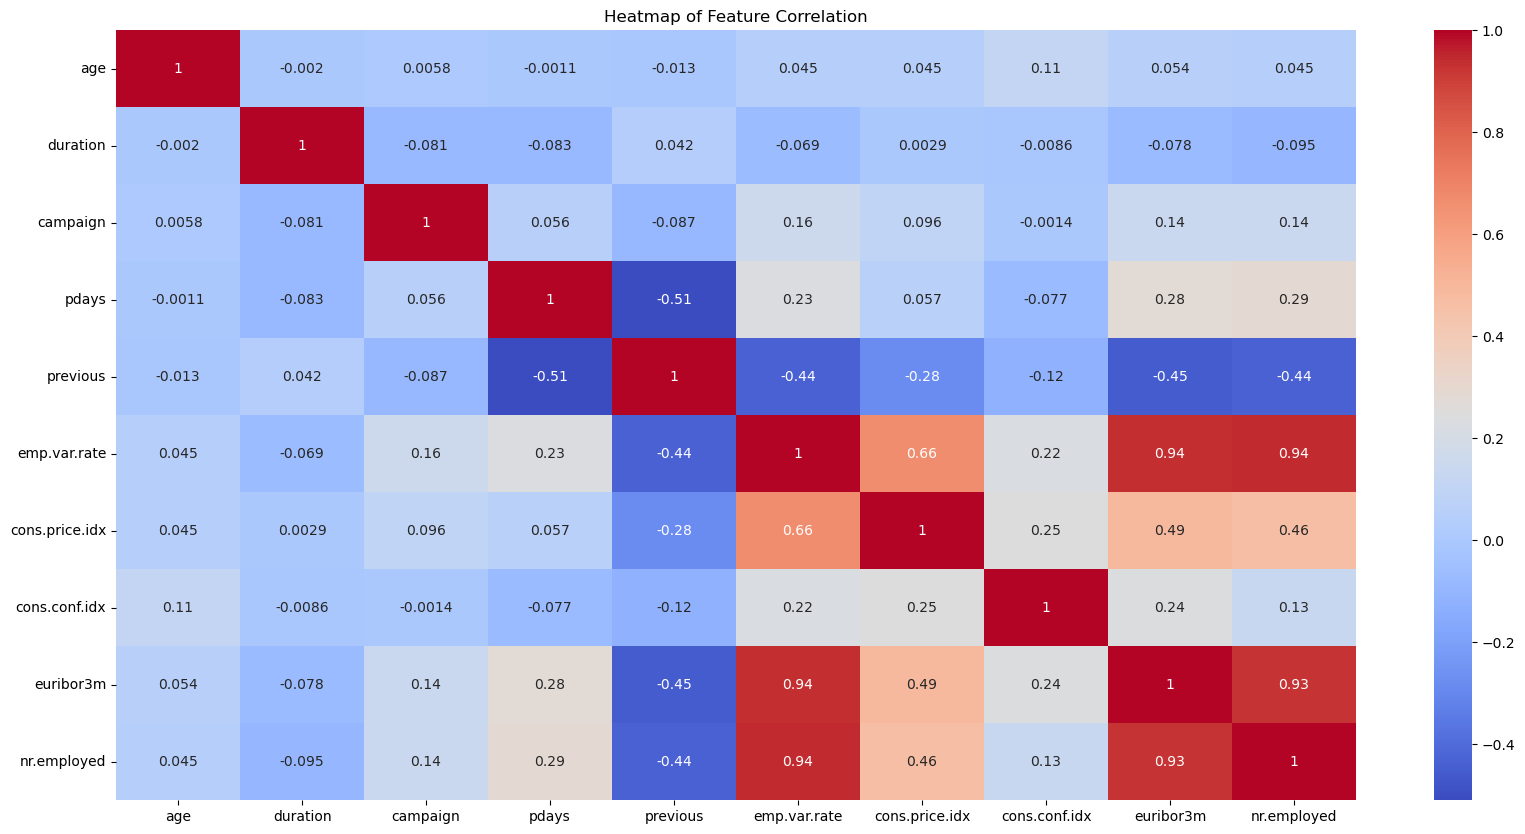

In [26]:
#membuat plot dengan heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_feature, annot=True, cmap='coolwarm',cbar=True)
plt.title('Heatmap of Feature Correlation')
plt.show()

Hasil dari pengecekan korealsi ada beberapa fitur yang memilki korelasi satu dengan yang lainnya

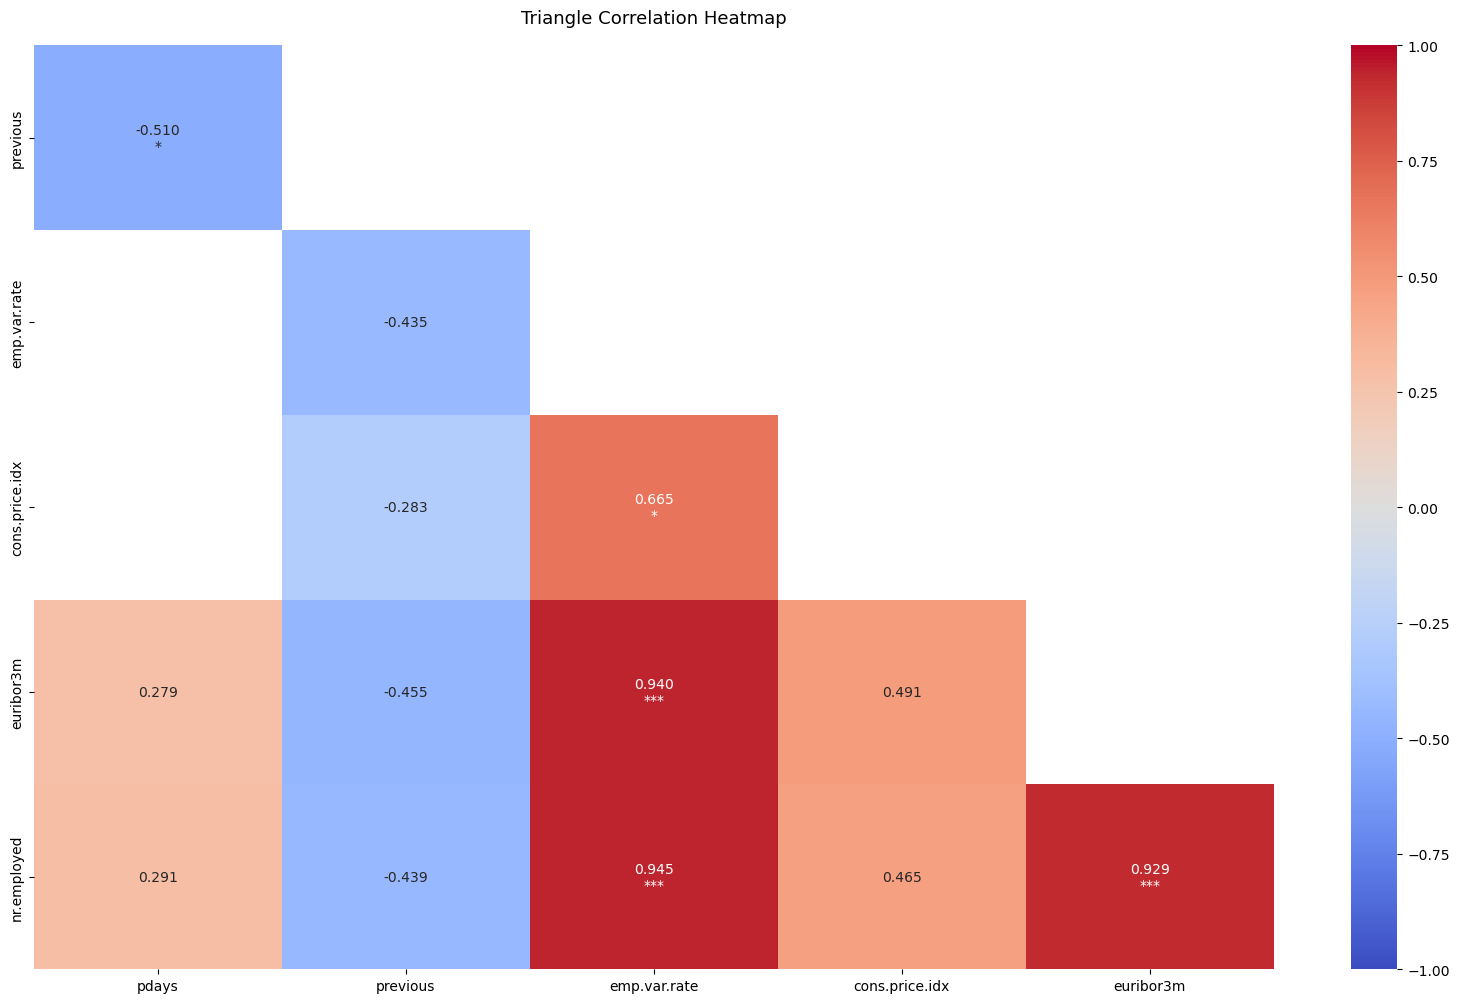

In [27]:
#pengecekkan korelasi yang dimana ditampilkan hanya untuk memiliki korelasi dengan minimum score 0.25 smpai -0.25
corr = df_num.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr) < cut_off
corr = corr[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.3f}"
          + ('' if abs(val) < extreme_1 else '\n*')
          + ('' if abs(val) < extreme_2 else '*')
          + ('' if abs(val) < extreme_3 else '*')
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='coolwarm')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 13}, pad=16)
plt.show()

Dapat dilihat dari hasil diatas terdapat 5 feature numerik yang memiliki korealsi satu dengan yang lainnya sehingga dalam kasus prediksi kali ini lebih baik tidak menggunakan model yang memilki suatu asumsi terhadap no multi korelasi

#### 4.5.1.2 Korelasi Antar Fitur Kategorikal

Karena Kategori dengan kategori maka menggunakan chisquare dan juga menggunkan Cramer's untuk bisa mengetahui seberapa besar korelasi terhadap satu fitur dengan fitur lainnya

In [28]:
# Fungsi untuk menghitung Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

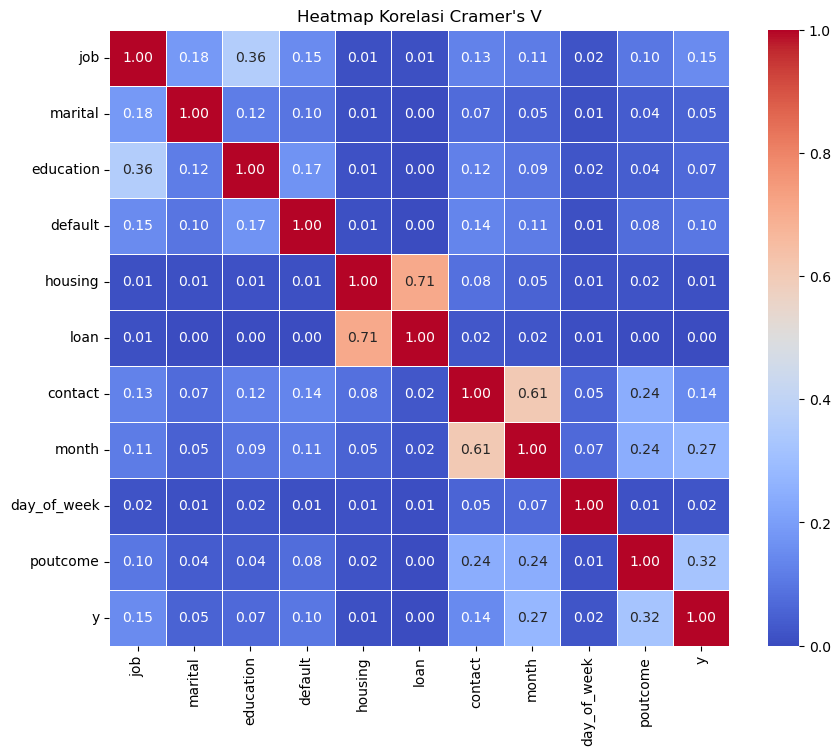

In [29]:
# Menghitung matriks Cramer's V
columns = df_cat.columns
corr_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        corr_matrix.loc[col1, col2] = cramers_v(df_cat[col1], df_cat[col2])

# Membuat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Heatmap Korelasi Cramer's V")
plt.show()

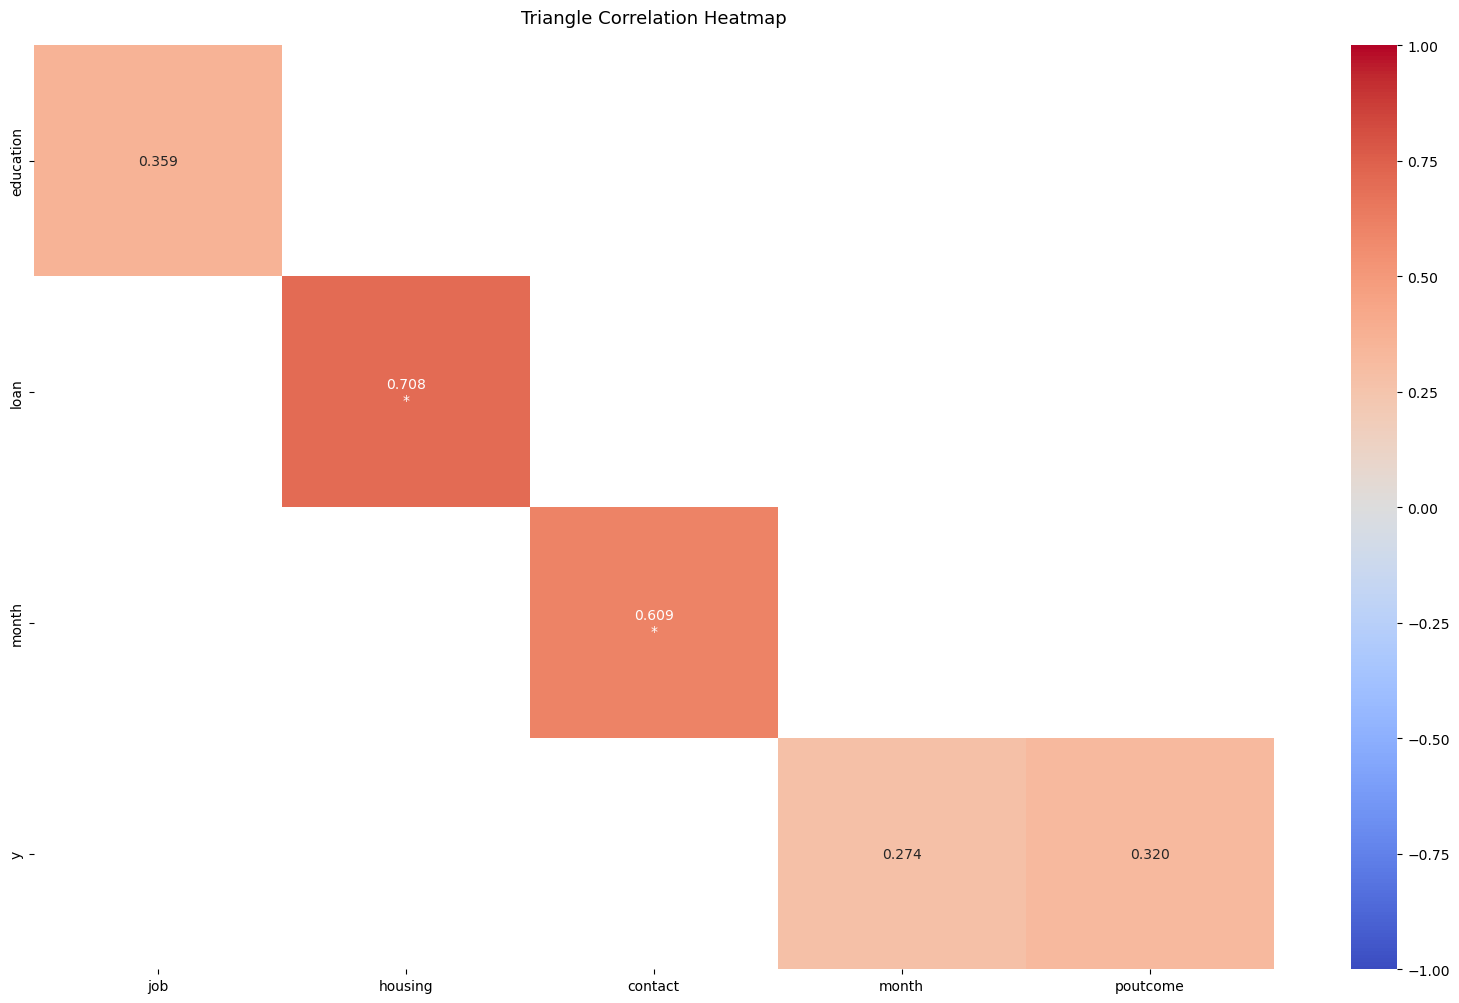

In [30]:
f, ax = plt.subplots(figsize=(20, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr_matrix) < cut_off
corr_matrix = corr_matrix[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr_matrix = corr_matrix.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.3f}"
          + ('' if abs(val) < extreme_1 else '\n*')
          + ('' if abs(val) < extreme_2 else '*')
          + ('' if abs(val) < extreme_3 else '*')
          for val in row] for row in corr_matrix.to_numpy()]
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=annot, fmt='', cmap='coolwarm')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 13}, pad=16)
plt.show()

apabila dilihat dalam kolom fitur cenderung tidak memiliki multi korelasi kecuali pada month dan poutcome

### 4.5.2 Korelasi Fitur Dengan Target

Dalam hal ini terdapat 2 Korelasi tergantung pada tipe datanya yakni numerik dan kategorik

#### 4.5.2.1 Korelasi Target Numerik

Pada bagian ini akan menggunakan pendekatan KendalTau dari Scipy karena akan menguji antara numerik dan kategorik

In [31]:
#mengambil data target
target = df['y']
#convert ke dataframe
df_target = pd.DataFrame(target)
#merged data
merged_num_tar = pd.concat([df_num,df_target],axis=1)
#convert yes no menjadi 0 dan 1 untuk cek korelasi
merged_num_tar['y'] = merged_num_tar['y'].map({'yes':1,'no':0})
merged_num_tar.head(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


In [32]:
#membuat var untuk meanmpung
listItem = [] 

#membuat fungsi untuk mengecek kolerasi kendal terhdap Exited
def corr(col):
  tmp = merged_num_tar.groupby(col)[['y']].mean().reset_index()
  tau, pval = stats.kendalltau(tmp[col],tmp['y'])
  result = 0
  if pval < 0.05:
        result = 'Berkaitan'
  else:
        result = 'Tidak Berkaitan'
  listItem.append([col, tau, pval,result])


for i in df_num.columns:
    corr(i)

#convert ke dataframe
corr_target = pd.DataFrame(columns=['Feature','Nilai Kendal','P-value','Hasil'], data=listItem)
corr_target

,Feature,Nilai Kendal,P-value,Hasil
0,age,0.267467,5.390466e-04,Berkaitan
1,duration,0.471013,8.782768e-159,Berkaitan
2,campaign,-0.706478,1.889372e-09,Berkaitan
3,pdays,0.032079,8.176342e-01,Tidak Berkaitan
4,previous,0.357143,2.750992e-01,Tidak Berkaitan
5,emp.var.rate,-0.600000,1.666612e-02,Berkaitan
6,cons.price.idx,0.058462,6.944365e-01,Tidak Berkaitan
7,cons.conf.idx,0.070769,6.310368e-01,Tidak Berkaitan
8,euribor3m,-0.295382,7.776643e-15,Berkaitan
9,nr.employed,-0.745455,7.595298e-04,Berkaitan


In [33]:
corr_target_kaitan = corr_target[corr_target['Hasil'] == 'Berkaitan']
corr_target_kaitan['Feature']

0             age
1        duration
2        campaign
5    emp.var.rate
8       euribor3m
9     nr.employed
Name: Feature, dtype: object

Dari hasil diatas dapat dilihat bahwasanya yang memilki korelasi terhadap target adalah : 
1. Age
2. duration
3. campaign
4. emp.var.rate
5. euribor3m
6. nr.employed

#### 4.5.2.2 Korelasi Target Kategorik

menggunakan chisquare karena keduanya bertipe kategorik

In [34]:
#buat var untuk menampung
listItem = []
#perualangan untuk langsung mengecek seluruh data categorical
for col in df_cat:
    cross = pd.crosstab(df_cat[col],df_cat['y'])
    pval = stats.chi2_contingency(cross).pvalue
    hasil = 0
    if hasil <0.05:
        hasil = 'Berkaitan'
    else:
        hasil = 'Tidak Berkaitan'
    #append data ke list
    listItem.append([col, pval, hasil])

#convert data
corr_target_cat = pd.DataFrame(columns=['Feature','P-value','Hasil'], data=listItem)
corr_target_cat
    
    

,Feature,P-value,Hasil
0,job,3.268412e-199,Berkaitan
1,marital,1.778423e-26,Berkaitan
2,education,3.746768e-38,Berkaitan
3,default,5.217541e-89,Berkaitan
4,housing,5.663793e-02,Berkaitan
5,loan,5.771532e-01,Berkaitan
6,contact,1.718741e-189,Berkaitan
7,month,0.000000e+00,Berkaitan
8,day_of_week,3.085755e-05,Berkaitan
9,poutcome,0.000000e+00,Berkaitan


Dapat dilihat dari hasil diatas bahwasanya semua kolom categorical memilki korelasi dengan Target apabila metode pengukurannya chisquare

## 4.6 Kesimpulan EDA

Kesimpulan yang didapatkan dalam eda ada beberapa hal yakni : 
1. Data target 'y' memiliki imbalanced mayoritas data memiliki target no atau tidak berlangganan dengan persentase 88.7% sedangkan yang berlangganan hanya 11.3% sehingga dalam kasus objectives project ini diperlukan handling yang bisa mengatasi kasus imblanced data target
2. Data ini memilki outliers yang cenderung besar sehingga perlu dihandling terlbih dahulu sebelum dimodelkan
3. Data ini memilki Multi Korelasi sehingga apabila diberikan model yang ada asumsi no multi correlation maka kecenderungan terhadap hasil akan tidak terlalu bagus
4. Data ini memilki Korelasi terhadap target sebagai berikut : 
    * Data Kategorik : 
        * 'job', 
        * 'marital', 
        * 'education', 
        * 'default', 
        * 'housing', 
        * 'loan', 
        * 'contact',
        * 'month', 
        * 'day_of_week', 
        * 'poutcome'
    * Data Numerik : 
        * age
        * duration 
        * campaign
        * emp.var.rate
        * euribor3m
        * nr.employed

sehingga dalam pembuatan model kedepannya akan menggunakan fitur fitur yang memilki korelasi terhadap target

# 5. Feature Engineering

Dalam bagian ini merupakan tahapan untuk memproses data terlebih dahulu sebelum masuk dibagaian modeling sehingga bisa memeberikan pengaruh performa model yang lebih bagus.

In [35]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 5.1 Splitting Dataset

dalam bagian ini akan melakukan splitting dataset yang memiliki persesntase 8:2 antara Train : Tes

- X berisi semua fitur dari dataset, kecuali kolom target `y`.
- y adalah kolom target `y`, yang akan diprediksi oleh model.

In [36]:
# pisahkan fitur dan target
X = df.drop('y', axis=1) #data train
y = df['y']  #data test

X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200) #splitting dengan random state serta pembagian train tes 8:2
print(f'X_train = {X_train.shape}')
print(f'y_train = {y_train.shape}')
print(f'X_test = {X_test.shape}')
print(f'y_test = {y_test.shape}')

X_train = (32940, 20)
y_train = (32940,)
X_test = (8236, 20)
y_test = (8236,)


## 5.2 Handling Outlier

Dalam bagian ini akan melakukan handling outlier dengan kolom numerik saja serta diberikan metode sesuai dengan distribusinya

In [38]:
#pengecekkan nilai skew pada setiap data numerik
num_col = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

listItem = []
for col in num_col:
  listItem.append([col, X_train[col].skew()])

pd.DataFrame(listItem, columns=['Column', 'Skew']).sort_values(by='Skew')

,Column,Skew
3,pdays,-4.815176
9,nr.employed,-1.052474
5,emp.var.rate,-0.727441
8,euribor3m,-0.714600
6,cons.price.idx,-0.237920
7,cons.conf.idx,0.299949
0,age,0.788888
1,duration,3.327575
4,previous,3.789297
2,campaign,4.827015


In [39]:
#membeuat var untuk list distribusi normal dan skew untuk mempermudah handling sesuai tipe datanya
listNorm = [] 
listSkew = []

for col in listItem:
  if col[1] > 0.5 or col[1] < -0.5:
    listSkew.append(col[0])
  else:
    listNorm.append(col[0])

print(f'Skew: {listSkew}')
print(f'Normal: {listNorm}')

Skew: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']
Normal: ['cons.price.idx', 'cons.conf.idx']


Dari hasil diatas kita mengetahui ada 2 golongan distribusi yakni skew dan normal sehingga akan di olah berbeda setiap golongannya. Perlu diingat dikarenakan tidak adanya outliers terhadap data Normal ketika di cek di EDA maka tidak ada handling terhadap Distribusi normal tetapi hanya skew saja

### 5.2.1 Metode Capping IQR

Dalam kasus ini tidak akan menggunakan data previous dan pdays karena berdasarkan data tersebut memang di setting menjadi angka tersebut untuk kasus pdays apabila belum pernah bertemu dengan orang

In [40]:
print(f'Skew: {listSkew}')

Skew: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']


In [41]:
# Menghapus kolom 'pdays' dan 'previous' dari daftar kolom yang akan dicapping
listSkewIQR = [col for col in listSkew if col not in ['pdays', 'previous']]

In [42]:
#hanling untuk distribusi skew dengan method iqr teknik capping
winsoriser_skew = Winsorizer(capping_method='quantiles',
                            tail='both',
                            fold=0.1,  # Menggunakan 5% untuk quantiles
                            variables= listSkewIQR)
X_train_capped = winsoriser_skew.fit_transform(X_train)
X_test_capped = winsoriser_skew.transform(X_test)


In [43]:
def diagnostic_plots(df, variable):
    #membuat funngsi untuk membuat visualisasi dari Hasil Handle outnlers dan tidak handle outliers


    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

age - Before Capping


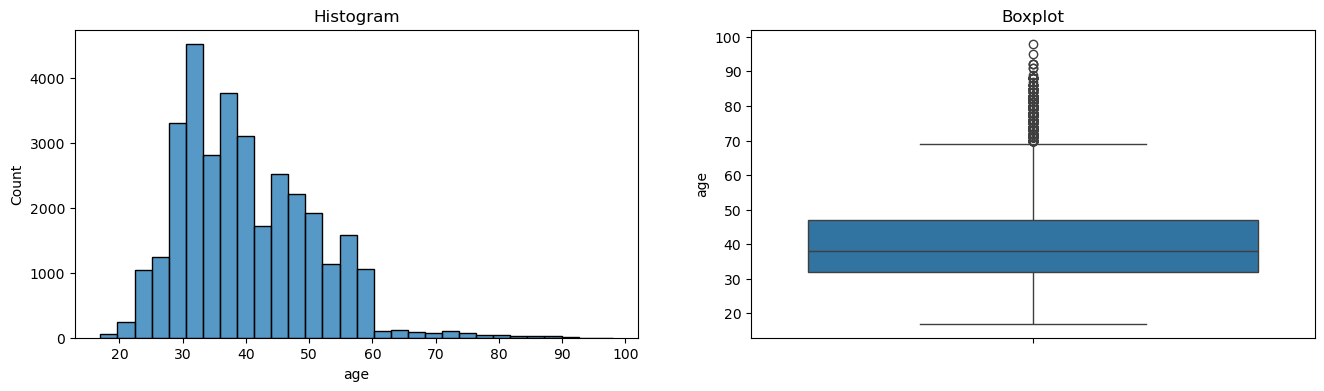


age - After Capping


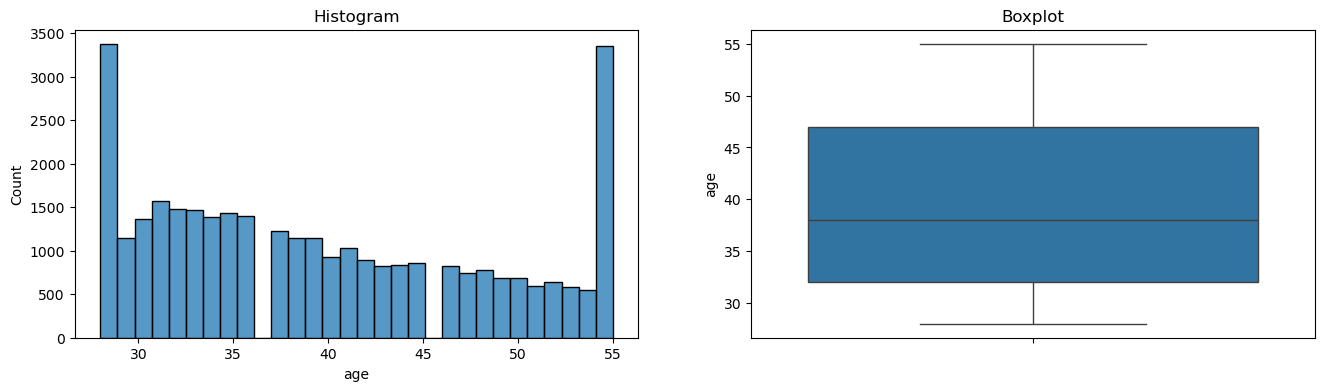

duration - Before Capping


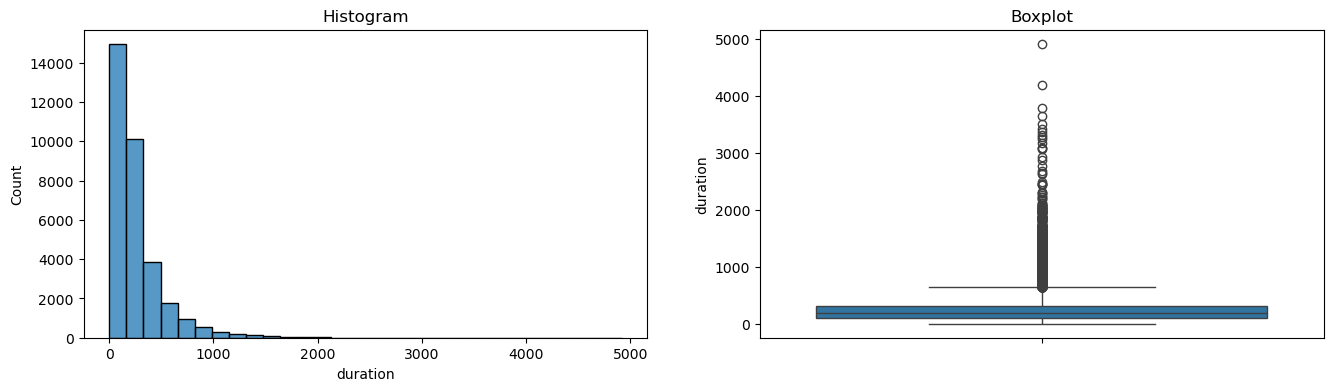


duration - After Capping


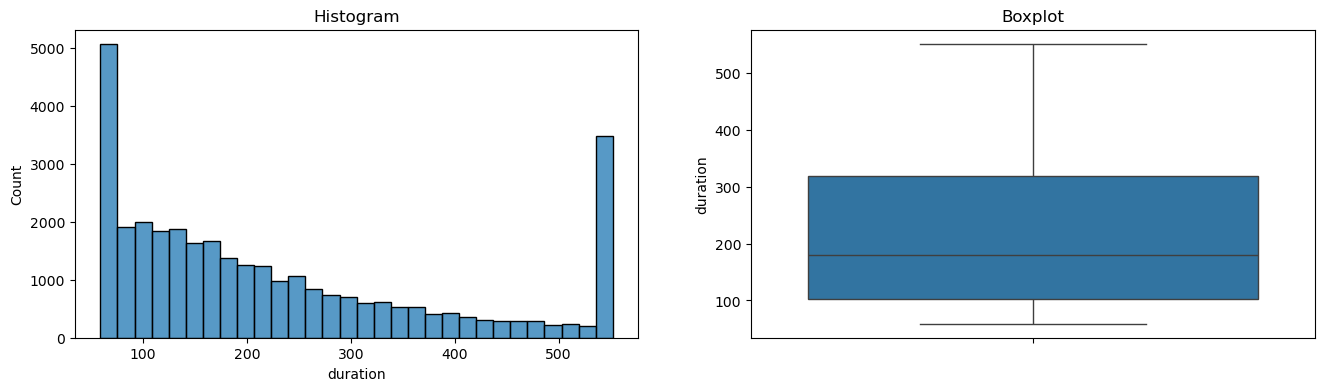

campaign - Before Capping


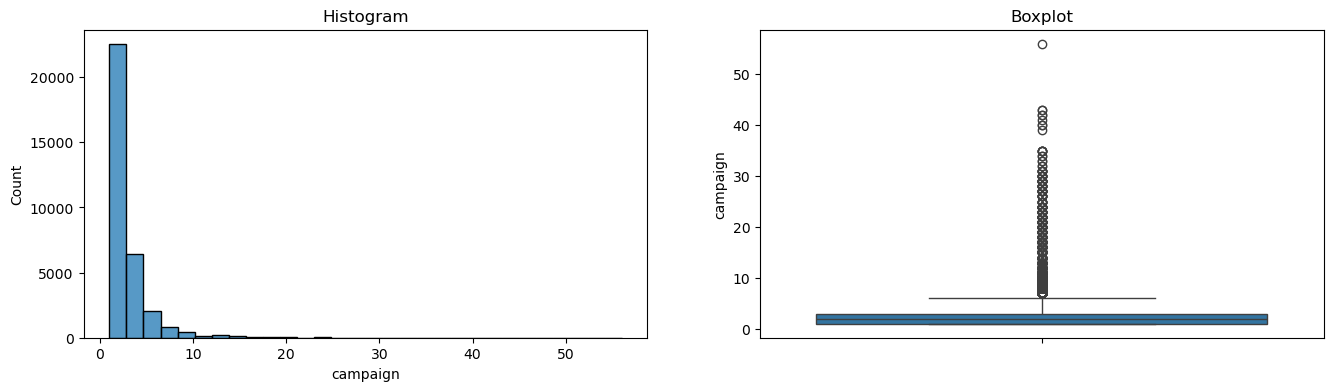


campaign - After Capping


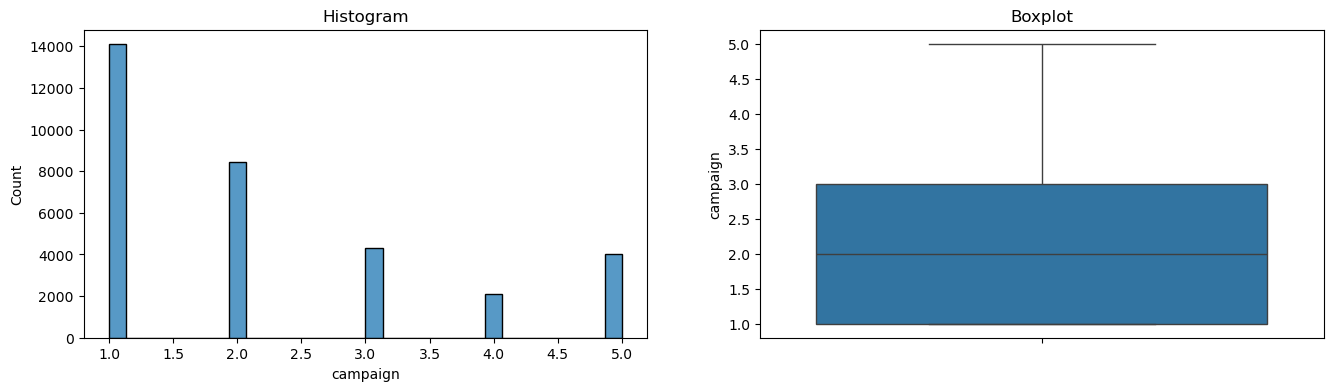

emp.var.rate - Before Capping


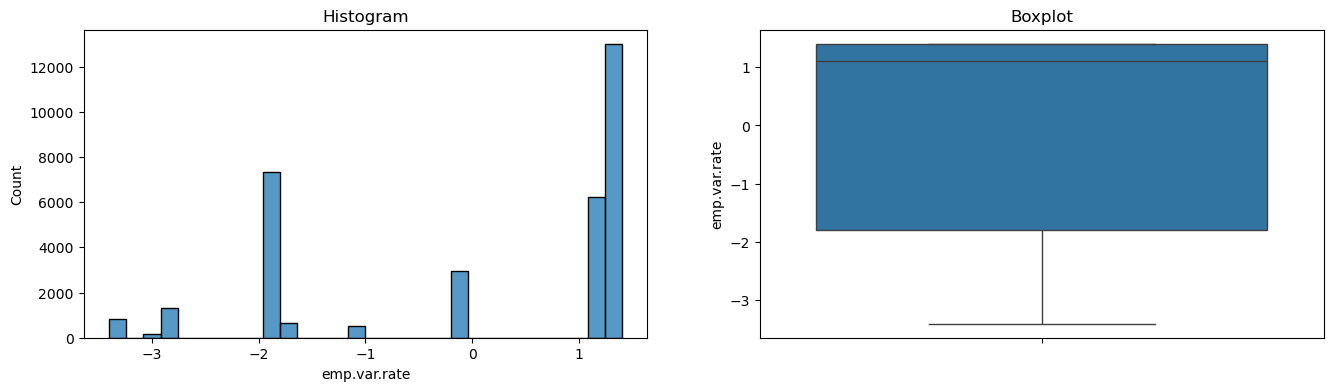


emp.var.rate - After Capping


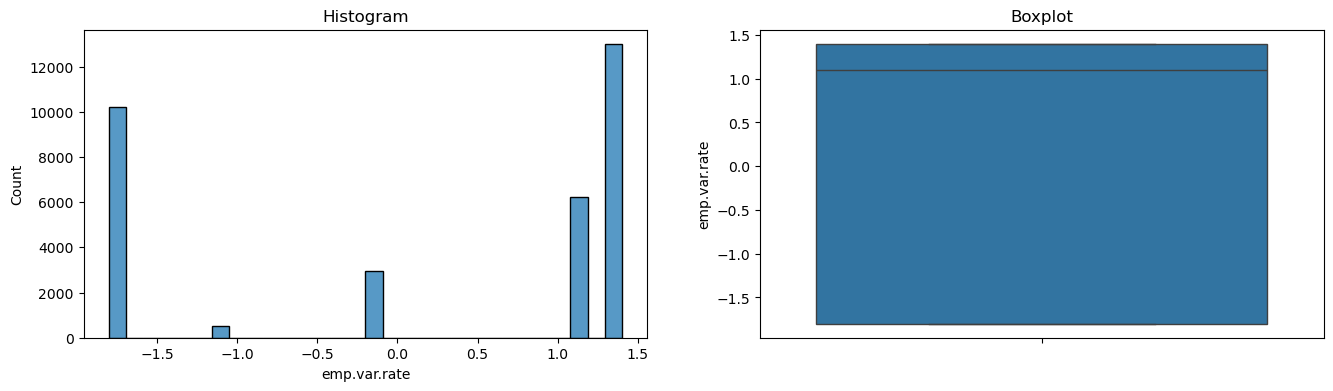

euribor3m - Before Capping


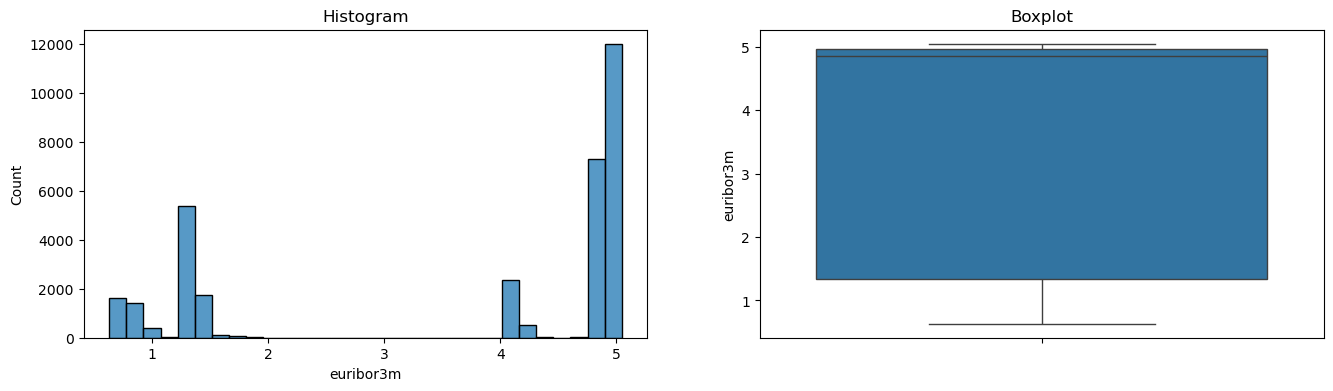


euribor3m - After Capping


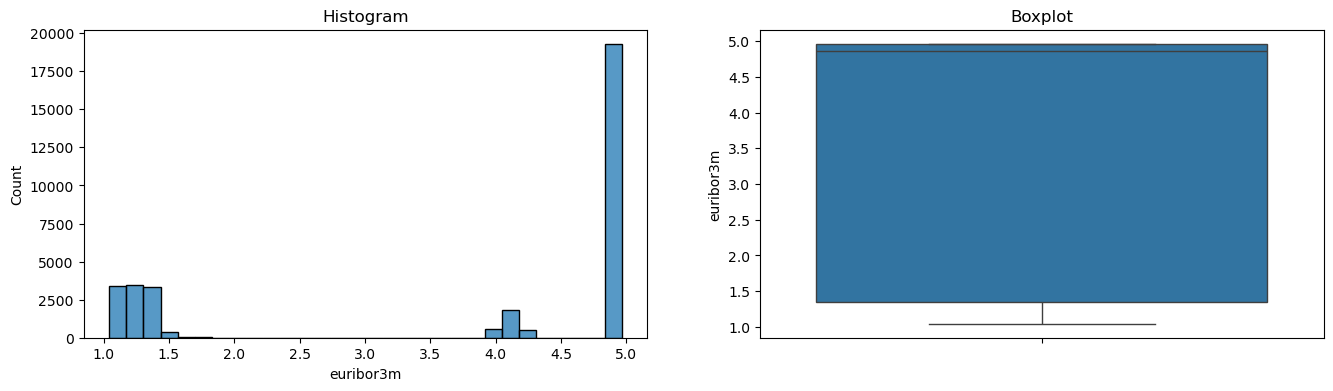

nr.employed - Before Capping


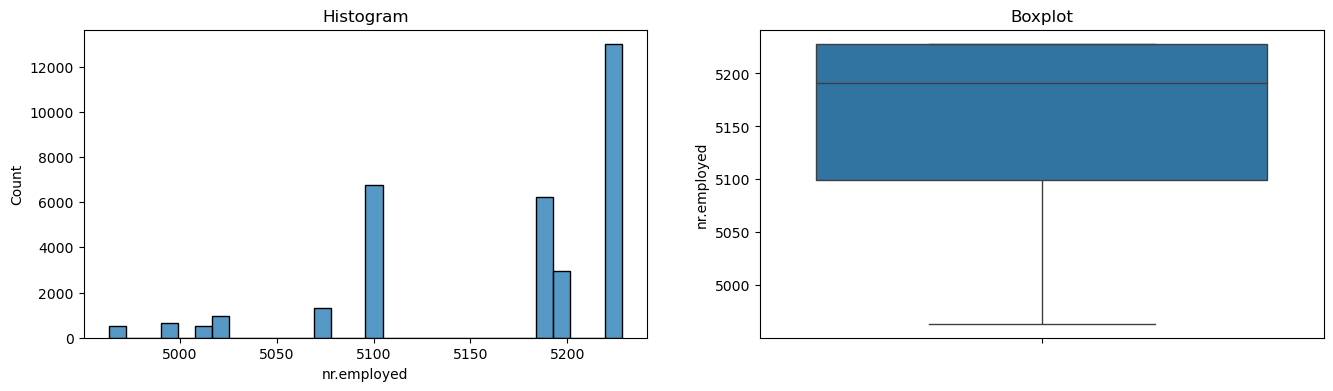


nr.employed - After Capping


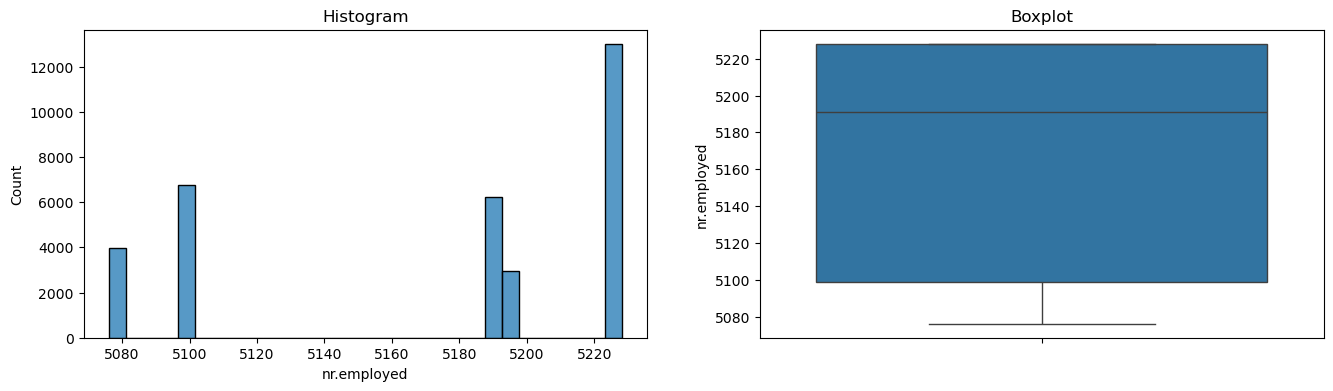

In [44]:
# Check the distribution before and after capping
for col in listSkewIQR:
  print(f'{col} - Before Capping')
  diagnostic_plots(X_train, col)

  print(f'\n{col} - After Capping')
  diagnostic_plots(X_train_capped, col)

Dapat dilihat setelah diberikan handling data sudah menjadi bersih dari outliers dengan metode CAPPING

### 5.4.3 Metode Gausian 

Untuk kasus pdays akan dipaksakan menggunakan gausian karena sudah tidak bisa menggunakan metode quantile aataupun iqr

In [45]:
#hadnling distribusi normal
winsoriser_norm = Winsorizer(capping_method='gaussian',
                            tail='both',
                            fold=3, 
                            variables='pdays'
                            ,missing_values='ignore')
X_train_capped = winsoriser_norm.fit_transform(X_train_capped) #train akan di fit_transfrom
X_test_capped = winsoriser_norm.transform(X_test_capped) #tes hanya akan di transform saja

pdays - Before Capping


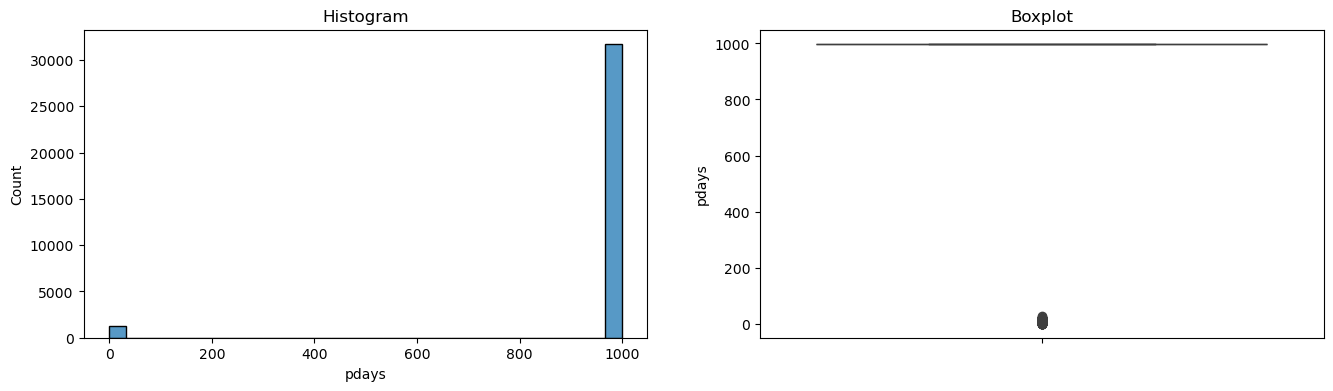


pdays - After Capping


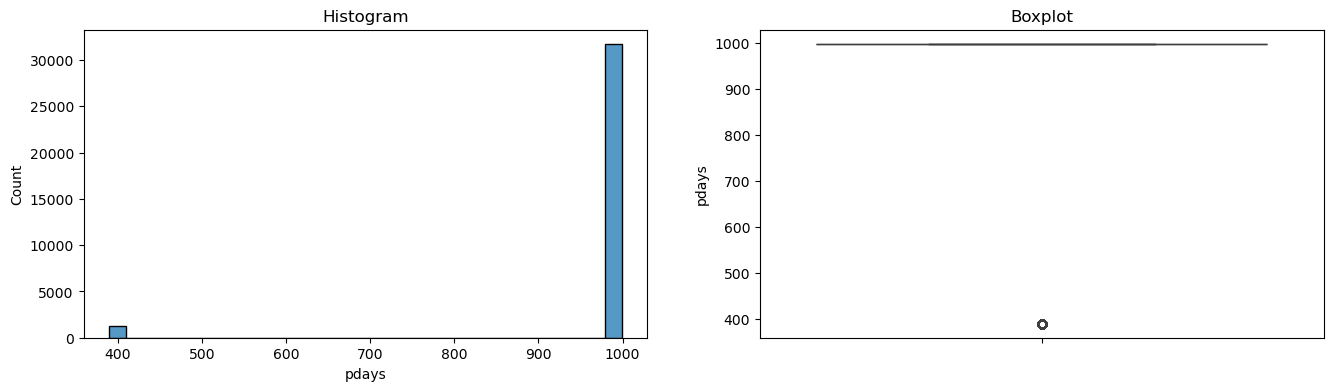

In [46]:
a = ['pdays']
# Check the distribution before and after capping
for col in a:
  print(f'{col} - Before Capping')
  diagnostic_plots(X_train, col)

  print(f'\n{col} - After Capping')
  diagnostic_plots(X_train_capped, col)

## 5.3 Pengelompokkan Dataset

Pada bagian ini akan mengelompokkan dataset sesuai dengan type pada data

In [47]:
## pengelompokan antara tipe numerical dan categorical

num_columns = X_train_capped.select_dtypes(include = np.number).columns.tolist() #numerik
cat_columns = X_train_capped.select_dtypes(include = ['object']).columns.tolist() #kategiri

print('Numeric Columns: ', num_columns)
print('Categorical Columns: ', cat_columns)

Numeric Columns:  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical Columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [48]:
#membuat var baru X_train_num dan X_train_cat yang berisikan sesuai dengan typenya
X_train_num = X_train_capped[num_columns]
X_train_cat = X_train_capped[cat_columns]

#penerapan ke X_test juga
X_test_num = X_test_capped[num_columns]
X_test_cat = X_test_capped[cat_columns]

## 5.4 Feature Selection

Pada bagian ini akan memilih feature apa saja yang akan digunakan untuk di modelkan sehingga diperlukan feature selection berdasarkan korelasi terhadap target seperti di EDA tetapi dengan kasus data yang sudah dibersihkan. Serta akan mengecek perbandingan terhadap pembersihan outliers apakah mempengaruhi korelasi terhadap data atau tidak

### 5.4.1 Feature Numerik

Dalam bagian ini akan mengecek secara langsung menggunakan kendal seperti pada EDA

In [49]:
#convert ke dataframe dengan menampung di dataset baru
df_target = pd.DataFrame(y_train)
#merged data
merged_numerik = pd.concat([X_train_num,df_target],axis=1)
#convert yes no menjadi 0 dan 1 untuk cek korelasi
merged_numerik['y'] = merged_numerik['y'].map({'yes':1,'no':0})
merged_numerik.head(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29194,42,130,1,999.0,1,-1.8,93.075,-47.1,1.405,5099.1,0
39567,28,180,2,999.0,0,-1.8,93.749,-34.6,1.044,5076.2,0


In [50]:
#membuat var untuk meanmpung
listItem = [] 

#membuat fungsi untuk mengecek kolerasi kendal terhadap Exited
def corr(col):
  tmp = merged_numerik.groupby(col)[['y']].mean().reset_index()
  tau, pval = stats.kendalltau(tmp[col],tmp['y'])
  result = 0
  if pval < 0.05:
        result = 'Berkaitan'
  else:
        result = 'Tidak Berkaitan'
  listItem.append([col, tau, pval,result])


for i in df_num.columns:
    corr(i)

#convert ke dataframe
corr_target = pd.DataFrame(columns=['Feature','Nilai Kendal','P-value','Hasil'], data=listItem)
corr_target

,Feature,Nilai Kendal,P-value,Hasil
0,age,-0.285714,3.361156e-02,Berkaitan
1,duration,0.595491,1.261854e-86,Berkaitan
2,campaign,-1.000000,1.666667e-02,Berkaitan
3,pdays,-1.000000,1.000000e+00,Tidak Berkaitan
4,previous,0.619048,6.904762e-02,Tidak Berkaitan
5,emp.var.rate,-0.714286,3.015873e-02,Berkaitan
6,cons.price.idx,0.058462,6.944365e-01,Tidak Berkaitan
7,cons.conf.idx,0.058462,6.944365e-01,Tidak Berkaitan
8,euribor3m,-0.137603,2.598051e-02,Berkaitan
9,nr.employed,-0.733333,5.555556e-02,Tidak Berkaitan


In [51]:
corr_fe_num = corr_target[corr_target['Hasil'] == 'Berkaitan']
corr_fe_num['Feature'] # untuk data yang sudah di handling outlier

0             age
1        duration
2        campaign
5    emp.var.rate
8       euribor3m
Name: Feature, dtype: object

In [52]:
#mengecek untuk data yang masih ada outlier
corr_target_kaitan['Feature']

0             age
1        duration
2        campaign
5    emp.var.rate
8       euribor3m
9     nr.employed
Name: Feature, dtype: object

Dapat dilihar hasil dari uji korelasi mengalami perubahan setelah handling extreme values, sehingga dalam kasus ini extreme values dapat mempengaruhi korelasi pada target dengan hasil akhir hanya ada 5 data saja: 
- age
- duration
- campaign
- emp.var.rate
- euribor3m

### 5.4.2 Feature Categorical

Dalam kasus ini akan langsung saja menggunakan semua data karena pada dasarnya tidak ada yang dirubah terhadap data categorical sehingga tidak perlu mengulangi langkah yang ada di EDA

In [53]:
fe_cat_correlation = corr_target_cat[corr_target_cat['Hasil']=='Berkaitan']
fe_cat_correlation['Feature']

0             job
1         marital
2       education
3         default
4         housing
5            loan
6         contact
7           month
8     day_of_week
9        poutcome
10              y
Name: Feature, dtype: object

Dengan hasil akhir semua memilki korelasi terhadap target

### 5.4.3 Kesimpulan Feature Selection

Dalam kasus ini akan memilih fitur numerik : 
1. age
2. duration
3. campaign
4. emp.var.rate
5. euribor3m

Fitur Kategorik :
1. 'job',
2. 'marital',
3. 'education',
4. 'default',
5. 'housing',
6. 'loan',
7. 'contact',
8. 'month',
9. 'day_of_week',
10. 'poutcome' 

Dimana hasil ini berbeda dengan dari EDA 

In [54]:
#buat var baru berisikan list terhadap fitur yang telah dipilih
num_col_selected = ['age','duration','campaign','emp.var.rate','euribor3m']
cat_col_selected = cat_columns

#transform ke train 
X_train_num_selection = X_train_num[num_col_selected]
X_train_cat_selection = X_train_cat[cat_col_selected]

#transform ke test
X_test_num_selection = X_test_num[num_col_selected]
X_test_cat_selection = X_test_cat[cat_col_selected]

#cek
X_train_cat_selection

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
29194,blue-collar,single,unknown,no,yes,no,cellular,apr,fri,failure
39567,student,single,unknown,no,yes,yes,cellular,apr,fri,nonexistent
31093,admin.,married,high.school,unknown,yes,no,cellular,may,wed,failure
12266,blue-collar,divorced,high.school,no,yes,no,telephone,jul,thu,nonexistent
23292,technician,married,professional.course,no,no,no,cellular,aug,wed,nonexistent
...,...,...,...,...,...,...,...,...,...,...
30948,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,tue,failure
11344,admin.,married,high.school,unknown,no,yes,telephone,jun,thu,nonexistent
784,blue-collar,single,basic.6y,no,yes,no,telephone,may,wed,nonexistent
12907,management,married,university.degree,no,yes,no,cellular,jul,tue,nonexistent


## 5.5 Balancing Dataset

Pada Tahapan ini akan melakukan ballancing dataset dengan menggunakan metode SMOTENC yakni Oversampling terhadap Minoritas

In [55]:
#concate X_train 
X_train_selected = pd.concat([X_train_num_selection,X_train_cat_selection], axis=1)
y = pd.DataFrame(y_train)

In [56]:
X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32940 entries, 29194 to 1819
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           32940 non-null  int64  
 1   duration      32940 non-null  int64  
 2   campaign      32940 non-null  int64  
 3   emp.var.rate  32940 non-null  float64
 4   euribor3m     32940 non-null  float64
 5   job           32940 non-null  object 
 6   marital       32940 non-null  object 
 7   education     32940 non-null  object 
 8   default       32940 non-null  object 
 9   housing       32940 non-null  object 
 10  loan          32940 non-null  object 
 11  contact       32940 non-null  object 
 12  month         32940 non-null  object 
 13  day_of_week   32940 non-null  object 
 14  poutcome      32940 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 4.0+ MB


In [57]:
categorical_columns = X_train_selected.select_dtypes(include=['object']).columns.to_list()
# Indeks kolom kategorikal
categorical_features = [X_train_selected.columns.get_loc(col) for col in categorical_columns]
#menggunakan SMOTENC
smotenc = SMOTENC(categorical_features=categorical_features, random_state=200, k_neighbors=5, sampling_strategy='minority')
#pisah menjadi 2 dataset yang berbeda
X_train_balanced, y_train_balanced = smotenc.fit_resample(X_train_selected, y)
y_train_balanced.value_counts()

y  
no     29184
yes    29184
Name: count, dtype: int64

In [58]:
X_train_balanced

,age,duration,campaign,emp.var.rate,euribor3m,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,42,130,1,-1.800000,1.405000,blue-collar,single,unknown,no,yes,no,cellular,apr,fri,failure
1,28,180,2,-1.800000,1.044000,student,single,unknown,no,yes,yes,cellular,apr,fri,nonexistent
2,46,293,1,-1.800000,1.334000,admin.,married,high.school,unknown,yes,no,cellular,may,wed,failure
3,29,178,1,1.400000,4.964000,blue-collar,divorced,high.school,no,yes,no,telephone,jul,thu,nonexistent
4,44,59,5,1.400000,4.964000,technician,married,professional.course,no,no,no,cellular,aug,wed,nonexistent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58363,39,552,3,1.400000,4.958826,admin.,married,basic.6y,no,no,no,telephone,jun,mon,nonexistent
58364,28,202,1,-1.724241,1.044000,student,single,high.school,no,yes,no,cellular,apr,tue,nonexistent
58365,47,362,1,-1.120304,1.044000,management,married,university.degree,no,yes,no,cellular,jul,thu,nonexistent
58366,37,552,1,-1.728082,1.123471,admin.,married,high.school,no,yes,no,cellular,may,thu,nonexistent


## 5.6 Columns Transformer

Pada bagian ini akan mengimplemtasikan pipeline sehingga proses akan lebih ringkas

In [59]:
#define final fitur yang diseleksi
num_col_selected = num_col_selected
ord_col_selected = ['education'] #fitur kategorik ordinal
nom_col_selected = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'] #fitur kategorik nominal

In [60]:
#define scaling
scaler = MinMaxScaler()
#define 
encoder_nom = OneHotEncoder(handle_unknown='ignore')  # Mengabaikan kategori yang tidak ada di data training
#define urutan ordinal untuk kolom eductaion
education_order = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'unknown'
]
#Inisialisasi OrdinalEncoder dengan urutan yang ditentukan
encoder_ord = OrdinalEncoder(categories=[education_order])


In [61]:
#Making column transformer for preprocessing
transformer = ColumnTransformer([
('scaler', scaler, num_col_selected),
('encoding nominal', encoder_nom, nom_col_selected),
('encoding ordinal', encoder_ord, ord_col_selected)
])

## 5.7 Concat Test Data

Pada bagian ini akan menggabungkan data test

In [62]:
X_test_final = pd.concat([X_test_num_selection,X_test_cat_selection], axis=1)
X_test_final = pd.DataFrame(X_test_final)
print(X_test_final.shape)

(8236, 15)


In [63]:
X_test_final.shape

(8236, 15)

In [64]:
y_test = pd.DataFrame(y_test)

In [65]:
y_test.shape

(8236, 1)

# 6. Model Definition

Pada model ini kita akan menggunakan 5 model yang berbeda untuk mencari model mana yang paling terbaik dalam melakukan predict yaitu:
- KNN
- SVM
- Decision Tree
- Random Forest
- Boosting (CatBosting) dipilih karena algoritma ini tidak memerlukan data target yang numerik. CatBoost dapat digunakan dengan data target kategorikal, sehingga sangat sesuai untuk dataset ini, yang berfokus pada prediksi klasifikasi (apakah nasabah akan berlangganan atau tidak).

In [66]:
#membuat pipeline untuk KNN
pipe_knn = Pipeline([
    ('transformer', transformer),
    ('classifier', KNeighborsClassifier())
])
#membuat pipeline untuk SVM
pipe_svc = Pipeline([
    ('transformer', transformer),
    ('classifier', SVC())]
)
#membuat pipeline untuk Decision Tree
pipe_dt = Pipeline([
    ('transformer', transformer),
    ('classifier', DecisionTreeClassifier())
])
#membuat pipeline untuk Random Forest
pipe_rf = Pipeline([
    ('transformer', transformer),
    ('classifier', RandomForestClassifier())
])
# Membuat pipeline untuk CatBoosting
pipe_cb = Pipeline([
    ('transformer', transformer),
    ('classifier', CatBoostClassifier(verbose=0)) 
])

# 7. Model Training

In [110]:
#train KNN
pipe_knn.fit(X_train_balanced,y_train_balanced)
#train SVM
pipe_svc.fit(X_train_balanced,y_train_balanced)
#train Decision Tree
pipe_dt.fit(X_train_balanced,y_train_balanced)
#train Random Forest
pipe_rf.fit(X_train_balanced,y_train_balanced)
#train CatBoosting
pipe_cb.fit(X_train_balanced,y_train_balanced)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Learning rate set to 0.058491
0:	learn: 0.6265853	total: 44.5ms	remaining: 44.4s
3:	learn: 0.4848042	total: 115ms	remaining: 28.7s
6:	learn: 0.4066831	total: 192ms	remaining: 27.2s
9:	learn: 0.3564773	total: 289ms	remaining: 28.6s
12:	learn: 0.3256567	total: 374ms	remaining: 28.4s
15:	learn: 0.3029748	total: 469ms	remaining: 28.8s
18:	learn: 0.2884589	total: 536ms	remaining: 27.7s
21:	learn: 0.2752181	total: 623ms	remaining: 27.7s
24:	learn: 0.2666147	total: 706ms	remaining: 27.5s
27:	learn: 0.2597076	total: 782ms	remaining: 27.2s
30:	learn: 0.2533920	total: 855ms	remaining: 26.7s
33:	learn: 0.2478231	total: 934ms	remaining: 26.5s
36:	learn: 0.2434532	total: 1.01s	remaining: 26.3s
39:	learn: 0.2393886	total: 1.08s	remaining: 25.8s
42:	learn: 0.2356521	total: 1.15s	remaining: 25.6s
45:	learn: 0.2331378	total: 1.23s	remaining: 25.5s
48:	learn: 0.2292683	total: 1.3s	remaining: 25.2s
51:	learn: 0.2266073	total: 1.37s	remaining: 25s
54:	learn: 0.2218070	total: 1.45s	remaining: 25s
57:	learn

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'emp.var.rate',
                                                   'euribor3m']),
                                                 ('encoding nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('encoding ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              'high.school',
                                                                              'professional.course',
                                                                              'university.degree',
                                                                              'unknown']]),
                                                  ['education'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001E681FD9520>)])

# 8. Baseline Evaluation

Dalam tahapan ini akan mengecek performa terhadap baseline model yang telah dimodel

menyimpan laporan kinerja model klasifikasi ke dalam sebuah dictionary (all_reports)

In [68]:
# Save Classification Report into a Dictionary
all_reports = {}
def performance_report(all_reports, model,y_train, y_pred_train, y_test, y_pred_test, name):
  score_reports = {
        'Train - f1_score': f1_score(y_train, y_pred_train, pos_label='yes'),
        'Test - f1_score': f1_score(y_test, y_pred_test, pos_label='yes'),
        'Train - F1 Mean - Cross Validation': cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='f1_macro').mean(),
        'Train - F1 Std - Cross Validation': cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='f1_macro').std()
  }
  all_reports[name] = score_reports
  return all_reports

## 8.1 Baseline Model KNN

In [100]:
# Predik data train dan test KNN
y_pred_train_knn_base = pipe_knn.predict(X_train_balanced)
y_pred_test_knn_base = pipe_knn.predict(X_test_final)

In [102]:
# Check the Report of model KNN
print('Report Train KNN: \n', classification_report(y_train_balanced, y_pred_train_knn_base))
print('Report Test KNN: \n', classification_report(y_test, y_pred_test_knn_base))

Report Train KNN: 
               precision    recall  f1-score   support

          no       0.95      0.89      0.92     29184
         yes       0.90      0.95      0.92     29184

    accuracy                           0.92     58368
   macro avg       0.92      0.92      0.92     58368
weighted avg       0.92      0.92      0.92     58368

Report Test KNN: 
               precision    recall  f1-score   support

          no       0.95      0.85      0.90      7353
         yes       0.34      0.63      0.44       883

    accuracy                           0.83      8236
   macro avg       0.64      0.74      0.67      8236
weighted avg       0.88      0.83      0.85      8236



- Hasil dari train terhadap model KKN cenderung bagus tetapi terdapat suatu kecenderungan dimana model lebih bisa memprediksi data yang syntetic yakni prediksi yes dari pada data original, dimana hal ini akan sangat berimplikasi penting terhadap test nanti yang akan nilainya cenderung turun.

- Nilai hasil pengujian mengalami penurunan yang signifikan, disebabkan oleh dataset yang imbalanced. Dalam kasus ini, performa model lebih tepat dievaluasi menggunakan F1-score karena ketidakseimbangan data membuat metrik akurasi kurang relevan.

In [71]:
all_reports = performance_report(all_reports, pipe_knn, y_train_balanced, y_pred_train_knn_base, y_test, y_pred_test_knn_base, 'KNN Baseline')
pd.DataFrame(all_reports)
eval_model = pd.DataFrame(all_reports)
eval_model

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

,KNN Baseline
Train - f1_score,0.922905
Test - f1_score,0.438163
Train - F1 Mean - Cross Validation,0.882494
Train - F1 Std - Cross Validation,0.036337


Hasil yang sangat underfit terhadap model KKN sehingga diperlukan metode lainnya untuk mendapati hasil yang lebih baik

## 8.2 Baseline Model SVM

In [103]:
# Predik data train dan test SVM
y_pred_svc_base = pipe_svc.predict(X_train_balanced)
y_pred_test_svc_base = pipe_svc.predict(X_test_final)

In [104]:
# Check the Report of model SVM
print('Report Train SVM: \n', classification_report(y_train_balanced, y_pred_svc_base))
print('Report Test SVM: \n', classification_report(y_test, y_pred_test_svc_base))

Report Train SVM: 
               precision    recall  f1-score   support

          no       0.96      0.86      0.91     29184
         yes       0.87      0.96      0.92     29184

    accuracy                           0.91     58368
   macro avg       0.92      0.91      0.91     58368
weighted avg       0.92      0.91      0.91     58368

Report Test SVM: 
               precision    recall  f1-score   support

          no       0.98      0.85      0.91      7353
         yes       0.40      0.82      0.54       883

    accuracy                           0.85      8236
   macro avg       0.69      0.84      0.72      8236
weighted avg       0.91      0.85      0.87      8236



- Pada nilai train f1 di model SVM ini cenderung lebih kecil hasilnya tetapi apabila dilihat dari kasus imbalanced data model ini lebih bagus untuk mempridiksi dari data yang original dibandingkan sintesis.

- Model SVM juga mengalami penurunan yang signifikan terhadap prediksi data test dimana model ini sangat overfit sehingga diperlukan pemlihan model yang lainnya dan akan dibandingkan di keputusan akhir untuk pemilihan model terbaik untuk di tuning.

In [74]:
all_reports = performance_report(all_reports, pipe_svc, y_train_balanced, y_pred_svc_base, y_test, y_pred_test_svc_base, 'SVM Baseline')
pd.DataFrame(all_reports)
eval_model = pd.DataFrame(all_reports)
eval_model

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

,KNN Baseline,SVM Baseline
Train - f1_score,0.922905,0.915100
Test - f1_score,0.438163,0.536640
Train - F1 Mean - Cross Validation,0.882494,0.901876
Train - F1 Std - Cross Validation,0.036337,0.025762


Dari hasil Tolak Ukur menggunakan F1 Score dapat diliihat sangat sangat overfit terhap model satu dan dua yakni KNN dan SVM tetapi model SVM memilki nilai f1 score yang lebih bagus terhadap KNN 

## 8.3 Baseline Model Decision Tree

In [105]:
# Predik data train dan test Decision Tree
y_pred_train_dt_base = pipe_dt.predict(X_train_balanced)
y_pred_test_dt_base = pipe_dt.predict(X_test_final)

In [106]:
# Check the Report of model Decision Tree
print('Report Train Decision Tree: \n', classification_report(y_train_balanced, y_pred_train_dt_base))
print('Report Test Decision Tree: \n', classification_report(y_test, y_pred_test_dt_base))

Report Train Decision Tree: 
               precision    recall  f1-score   support

          no       1.00      1.00      1.00     29184
         yes       1.00      1.00      1.00     29184

    accuracy                           1.00     58368
   macro avg       1.00      1.00      1.00     58368
weighted avg       1.00      1.00      1.00     58368

Report Test Decision Tree: 
               precision    recall  f1-score   support

          no       0.95      0.92      0.93      7353
         yes       0.46      0.57      0.51       883

    accuracy                           0.88      8236
   macro avg       0.70      0.74      0.72      8236
weighted avg       0.89      0.88      0.89      8236



- Dapat dilihat hasil dari prediksi train untuk model Decision Tree sangat bagus dimana 1.0 tetapi tetap perlu di cross check dengan hasil dari test.
- Untuk pengecekkan test pada Decision Tree jatuh sekali untuk parameter f1 score karena masih belum bisa memprediksi label yang minoritas secara bagus

In [77]:
all_reports = performance_report(all_reports, pipe_dt, y_train_balanced, y_pred_train_dt_base, y_test, y_pred_test_dt_base, 'DT Baseline')
pd.DataFrame(all_reports)
eval_model = pd.DataFrame(all_reports)
eval_model

,KNN Baseline,SVM Baseline,DT Baseline
Train - f1_score,0.922905,0.915100,0.999777
Test - f1_score,0.438163,0.536640,0.506815
Train - F1 Mean - Cross Validation,0.882494,0.901876,0.915186
Train - F1 Std - Cross Validation,0.036337,0.025762,0.056031


Model Decision Tree baseline cenderung lebih bagus dibanding KNN tetapi lebih buruk dibanding degnan SVM 

## 8.4 Baseline Model Random Forest

In [78]:
# Predik data train dan test Random Forest
y_pred_train_rf = pipe_rf.predict(X_train_balanced)
y_pred_test_rf = pipe_rf.predict(X_test_final)

In [80]:
# Check the Report of model Random Forest
print('Report Train Random Forest: \n', classification_report(y_train_balanced, y_pred_train_rf))
print('Report Test Random Forest: \n', classification_report(y_test, y_pred_test_rf))

Report Train Random Forest: 
               precision    recall  f1-score   support

          no       1.00      1.00      1.00     29184
         yes       1.00      1.00      1.00     29184

    accuracy                           1.00     58368
   macro avg       1.00      1.00      1.00     58368
weighted avg       1.00      1.00      1.00     58368

Report Test Random Forest: 
               precision    recall  f1-score   support

          no       0.96      0.93      0.94      7353
         yes       0.54      0.66      0.59       883

    accuracy                           0.90      8236
   macro avg       0.75      0.79      0.77      8236
weighted avg       0.91      0.90      0.91      8236



- Pada hasil train diatas bisa dilihat sangat bagus, model dapat memprediksi dengan sangat bagus terhadap target.
- Pada hasil test juga sama seperti model yang lainnya dimana pada test model masih belum bisa memprediksi secara bagus untuk label yang minoritas sehingga akan sangat overfit apabila berparameter f1-score

In [82]:
all_reports = performance_report(all_reports, pipe_rf, y_train_balanced, y_pred_train_rf, y_test, y_pred_test_rf, 'RF Baseline')
pd.DataFrame(all_reports)
eval_model = pd.DataFrame(all_reports)
eval_model

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

,KNN Baseline,SVM Baseline,DT Baseline,RF Baseline
Train - f1_score,0.922905,0.915100,0.999777,0.999777
Test - f1_score,0.438163,0.536640,0.506815,0.591233
Train - F1 Mean - Cross Validation,0.882494,0.901876,0.915186,0.935154
Train - F1 Std - Cross Validation,0.036337,0.025762,0.056031,0.048687


Dapat dilihat RF Baseline memilki hasil paling bagus diantara yang lainnya

## 8.5 Baseline Model CatBoosting

In [83]:
# Predik data train dan test Random Forest
y_pred_train_cb_base = pipe_cb.predict(X_train_balanced)
y_pred_test_cb_base = pipe_cb.predict(X_test_final)

In [84]:
# Check the Report of model CatBoosting
print('Report Train CatBoosting: \n', classification_report(y_train_balanced, y_pred_train_cb_base))
print('Report Test CatBoosting: \n', classification_report(y_test, y_pred_test_cb_base))

Report Train CatBoosting: 
               precision    recall  f1-score   support

          no       0.98      0.94      0.96     29184
         yes       0.95      0.98      0.96     29184

    accuracy                           0.96     58368
   macro avg       0.96      0.96      0.96     58368
weighted avg       0.96      0.96      0.96     58368

Report Test CatBoosting: 
               precision    recall  f1-score   support

          no       0.96      0.92      0.94      7353
         yes       0.52      0.69      0.59       883

    accuracy                           0.90      8236
   macro avg       0.74      0.81      0.77      8236
weighted avg       0.91      0.90      0.90      8236



In [85]:
all_reports = performance_report(all_reports, pipe_cb, y_train_balanced, y_pred_train_cb_base, y_test, y_pred_test_cb_base, 'CB Baseline')
pd.DataFrame(all_reports)
eval_model = pd.DataFrame(all_reports)
eval_model

,KNN Baseline,SVM Baseline,DT Baseline,RF Baseline,CB Baseline
Train - f1_score,0.922905,0.915100,0.999777,0.999777,0.960922
Test - f1_score,0.438163,0.536640,0.506815,0.591233,0.591985
Train - F1 Mean - Cross Validation,0.882494,0.901876,0.915186,0.935154,0.929556
Train - F1 Std - Cross Validation,0.036337,0.025762,0.056031,0.048687,0.056128


Pada kasus ini model Cat Boosting memilki hasil yang paling bagus diantara yang lainnya tetapi mengorbankan waktu komputasi dan semua model yang telah dibuat dengan parameter default atau baseline nya masih ooverfit dan tidak bisa memprediksi secara bagus berdasarkan f1-score terhadap data testing yang imblanacedd

# 9. Hyper Parameter Tunning

In [86]:
# Menentukan pipeline dengan CatBoost
pipe_cb = Pipeline([
    ('transformer', transformer),
    ('classifier', CatBoostClassifier(verbose=3))
])

# Definisikan parameter grid untuk CatBoost
param_grid = {
    'classifier__iterations': [50, 100, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__depth': [4, 6, 8],
    'classifier__l2_leaf_reg': [1, 3, 5],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Inisialisasi GridSearchCV dengan pipeline
grid_search = GridSearchCV(
    estimator=pipe_cb,
    param_grid=param_grid,
    verbose=3,
    cv=3,  # Jumlah fold untuk cross-validation
    scoring='f1_macro',  # Gunakan metrik sesuai kebutuhan
    n_jobs=5  # Untuk memanfaatkan semua CPU
)

# Fit model
grid_search.fit(X_train_balanced, y_train_balanced)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
0:	learn: 0.4918825	total: 60.8ms	remaining: 18.2s
3:	learn: 0.2963918	total: 263ms	remaining: 19.5s
6:	learn: 0.2437402	total: 530ms	remaining: 22.2s
9:	learn: 0.2219201	total: 697ms	remaining: 20.2s
12:	learn: 0.2105517	total: 874ms	remaining: 19.3s
15:	learn: 0.2019985	total: 1.02s	remaining: 18.2s
18:	learn: 0.1956814	total: 1.2s	remaining: 17.7s
21:	learn: 0.1883793	total: 1.35s	remaining: 17s
24:	learn: 0.1838470	total: 1.51s	remaining: 16.7s
27:	learn: 0.1770772	total: 1.78s	remaining: 17.3s
30:	learn: 0.1729162	total: 1.98s	remaining: 17.1s
33:	learn: 0.1691065	total: 2.14s	remaining: 16.8s
36:	learn: 0.1665734	total: 2.29s	remaining: 16.2s
39:	learn: 0.1637679	total: 2.45s	remaining: 15.9s
42:	learn: 0.1614735	total: 2.6s	remaining: 15.6s
45:	learn: 0.1576293	total: 2.77s	remaining: 15.3s
48:	learn: 0.1543436	total: 2.92s	remaining: 14.9s
51:	learn: 0.1518786	total: 3.08s	remaining: 14.7s
54:	learn: 0.1499256	total

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'duration',
                                                                          'campaign',
                                                                          'emp.var.rate',
                                                                          'euribor3m']),
                                                                        ('encoding '
                                                                         'nominal',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['job',
                                                                          'marital',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome']),
                                                                        ('encoding '
                                                                         'ordinal',
                                                                         Ordina...
                                                                                                     'university.degree',
                                                                                                     'unknown']]),
                                                                         ['education'])])),
                                       ('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x000001E681FD9520>)]),
             n_jobs=5,
             param_grid={'classifier__depth': [4, 6, 8],
                         'classifier__iterations': [50, 100, 300],
                         'classifier__l2_leaf_reg': [1, 3, 5],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring='f1_macro', verbose=3)

In [87]:
# Lihat hasil
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'classifier__depth': 8, 'classifier__iterations': 300, 'classifier__l2_leaf_reg': 3, 'classifier__learning_rate': 0.2, 'classifier__subsample': 1.0}
Best score found:  0.9324959334745765


Dari hasil diatas dapat dilihat bahwa best parameternya adalah : 

{'classifier__depth': 8, 'classifier__iterations': 300, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.2, 'classifier__subsample': 0.8}

Deengan Score f1 nya 0.9341622904234029

In [88]:
# Gunakan parameter terbaik untuk model akhir
best_model = grid_search.best_estimator_

# Predik data train dan test Random Forest
y_pred_train_cb_tuned = best_model.predict(X_train_balanced)
y_pred_test_cb_tuned = best_model.predict(X_test_final)

In [89]:
# Check the Report of model CatBoostingTuning
print('Report Train CatBoostingTuning: \n', classification_report(y_train_balanced, y_pred_train_cb_tuned))
print('Report Test CatBoostingTuning: \n', classification_report(y_test, y_pred_test_cb_tuned))

Report Train CatBoostingTuning: 
               precision    recall  f1-score   support

          no       0.99      0.97      0.98     29184
         yes       0.97      0.99      0.98     29184

    accuracy                           0.98     58368
   macro avg       0.98      0.98      0.98     58368
weighted avg       0.98      0.98      0.98     58368

Report Test CatBoostingTuning: 
               precision    recall  f1-score   support

          no       0.96      0.93      0.94      7353
         yes       0.53      0.67      0.59       883

    accuracy                           0.90      8236
   macro avg       0.74      0.80      0.77      8236
weighted avg       0.91      0.90      0.91      8236



In [90]:
all_reports = performance_report(all_reports, best_model, y_train_balanced, y_pred_train_cb_tuned, y_test, y_pred_test_cb_tuned, 'CB Tuned')
pd.DataFrame(all_reports)
eval_model = pd.DataFrame(all_reports)
eval_model

0:	learn: 0.4712400	total: 42.7ms	remaining: 12.8s
3:	learn: 0.2756695	total: 133ms	remaining: 9.82s
6:	learn: 0.2190151	total: 223ms	remaining: 9.32s
9:	learn: 0.1961690	total: 330ms	remaining: 9.57s
12:	learn: 0.1807753	total: 447ms	remaining: 9.86s
15:	learn: 0.1713917	total: 537ms	remaining: 9.54s
18:	learn: 0.1625709	total: 650ms	remaining: 9.62s
21:	learn: 0.1549971	total: 742ms	remaining: 9.38s
24:	learn: 0.1499875	total: 853ms	remaining: 9.38s
27:	learn: 0.1443095	total: 942ms	remaining: 9.15s
30:	learn: 0.1383302	total: 1.02s	remaining: 8.86s
33:	learn: 0.1332310	total: 1.14s	remaining: 8.94s
36:	learn: 0.1298851	total: 1.24s	remaining: 8.81s
39:	learn: 0.1245011	total: 1.33s	remaining: 8.66s
42:	learn: 0.1196593	total: 1.44s	remaining: 8.61s
45:	learn: 0.1153049	total: 1.53s	remaining: 8.46s
48:	learn: 0.1119281	total: 1.62s	remaining: 8.3s
51:	learn: 0.1090451	total: 1.73s	remaining: 8.26s
54:	learn: 0.1068676	total: 1.83s	remaining: 8.15s
57:	learn: 0.1033620	total: 1.92s	r

,KNN Baseline,SVM Baseline,DT Baseline,RF Baseline,CB Baseline,CB Tuned
Train - f1_score,0.922905,0.915100,0.999777,0.999777,0.960922,0.977204
Test - f1_score,0.438163,0.536640,0.506815,0.591233,0.591985,0.590295
Train - F1 Mean - Cross Validation,0.882494,0.901876,0.915186,0.935154,0.929556,0.930984
Train - F1 Std - Cross Validation,0.036337,0.025762,0.056031,0.048687,0.056128,0.058912


CatBoost Baseline memiliki nilai f1_score yang sedikit lebih tinggi pada data uji dibandingkan CatBoost Tuned.
Ini menunjukkan bahwa CB Baseline lebih baik dalam memperkirakan kinerja model pada data yang belum pernah dilihat.
Jadi, dalam konteks pengujian, CatBoost Baseline adalah pilihan yang lebih baik

# 10. Save Model

Pada tahap ini dilakukan saving model

In [113]:
#save model CatBoost
with open('pipe_cb.pkl', 'wb') as file_1:
  joblib.dump(pipe_cb, file_1)

In [109]:
pipe_cb

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'emp.var.rate',
                                                   'euribor3m']),
                                                 ('encoding nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('encoding ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              'high.school',
                                                                              'professional.course',
                                                                              'university.degree',
                                                                              'unknown']]),
                                                  ['education'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001E681FD9520>)])

# 11. Conceptual Problem

1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !

    - Latar Belakang Bagging: Bagging (Bootstrap Aggregating) dikembangkan untuk mengurangi overfitting dan variansi model. Ini bertujuan membuat prediksi lebih stabil dan akurat dengan menggabungkan beberapa model yang dilatih pada data berbeda.
    - cara kerja bagging: Bagging bekerja dengan mengambil subset data secara acak (bootstrap) dengan penggantian dari dataset asli, melatih model yang sama pada tiap subset, lalu menggabungkan prediksi model-model tersebut untuk mengurangi variansi dan meningkatkan akurasi.

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !

    Random Forest dan CatBoost adalah algoritma machine learning yang umum digunakan untuk tugas klasifikasi dan regresi, tetapi mereka memiliki pendekatan yang berbeda dalam cara kerjanya.
    - Random Forest bekerja dengan menciptakan banyak pohon keputusan (decision trees) dari subset data yang berbeda menggunakan teknik bagging. Setiap pohon dilatih secara independen, dan untuk menghasilkan prediksi akhir, hasil dari semua pohon digabungkan. Proses ini biasanya dilakukan dengan voting mayoritas untuk klasifikasi atau rata-rata untuk regresi. Dengan pendekatan ini, Random Forest dapat mengurangi risiko overfitting dan meningkatkan akurasi model.
    - CatBoost (Categorical Boosting) adalah algoritma boosting yang dirancang khusus untuk menangani data kategorikal dengan lebih efektif. CatBoost membangun model secara bertahap, di mana setiap model baru bertujuan untuk memperbaiki kesalahan yang dibuat oleh model sebelumnya. Selain itu, CatBoost menggunakan teknik khusus untuk mengonversi data kategorikal menjadi numerik, sehingga informasi penting tetap terjaga. Proses iteratif ini memungkinkan CatBoost untuk mengurangi kesalahan secara bertahap dan sangat efektif dalam menghasilkan model yang akurat, terutama pada dataset dengan banyak fitur kategorikal.

    Kesimpulannya, Random Forest menggabungkan banyak pohon keputusan yang dilatih secara independen untuk meningkatkan akurasi, sedangkan CatBoost secara iteratif memperbaiki kesalahan model sebelumnya dengan fokus pada pengolahan data kategorikal, sehingga keduanya memiliki keunggulan dalam konteks penggunaan yang berbeda.
    
3. Jelaskan apa yang dimaksud dengan Cross Validation !

    Cross Validation adalah teknik yang digunakan untuk mengevaluasi kinerja model machine learning dengan cara membagi dataset menjadi beberapa subset (folds). Tujuannya adalah untuk mengurangi variansi dan memastikan bahwa model tidak hanya baik dalam memprediksi data yang dilatih, tetapi juga dalam memprediksi data yang belum pernah dilihat sebelumnya.

# 12. Pengambilan Kesimpulan

Dalam bagian ini akan menjelaskan beberapa kesimpulan yang ditemukan dalam menyelesaikan project

## 12.1 Kesimpulan EDA

1. Dataset ini sangat imbalanced dengan proporsi 88:12 sehingga diperlukan handling terhadap imbalanced data
2. Ada Multi Korelasi antar fitur sehingga lebih baik apabila menggunakan model yang tidak ada asumsi no multi corelation
3. Ada banyak outliers terhadap dataset ini yang juga hal ini perlu dihandling dengan cara yang tepat

## 12.2 Kesimpulan Model

1. Model Terbaik: Model terbaik adalah CatBoosting, berdasarkan F1-Score yang diperoleh. Namun, model ini memiliki kelemahan yaitu waktu komputasi yang lebih lama dibandingkan dengan KNN dan Decision Tree.

2. Imbalanced Dataset: Pada kasus imbalanced dataset, model masih belum dapat memprediksi kelas minoritas secara optimal. Hal ini disebabkan oleh penanganan variance terhadap dataset di training yang sudah diatasi dengan metode Capping, sehingga jumlah data berkurang. Setelahnya, pendekatan balancing data diterapkan, tetapi model tetap menghadapi tantangan karena pola kelas minoritas yang lebih sedikit dibandingkan dengan kelas mayoritas. Akibatnya, skor uji masih menunjukkan overfitting, meskipun hasilnya lebih baik dibandingkan tanpa penanganan ketidakseimbangan.

3. Hasil Cross Validation: Hasil Cross Validation menunjukkan bahwa model CatBoost (CB_Baseline) memiliki kinerja yang baik, dengan nilai F1-Score yang memuaskan pada data latih dan variansi error yang rendah.

4. Penanganan Outlier: Beberapa fitur tidak ditangani outlier-nya karena nilai tersebut diatur secara default dan tidak mengalami perubahan.

## 12.3 Kesimpulan Bisnis

1. Meningkatkan Efisiensi Pemasaran: Dengan memanfaatkan model prediksi yang akurat, bank dapat lebih efektif menargetkan nasabah yang berpotensi untuk berlangganan deposito berjangka, sehingga meningkatkan efisiensi kampanye pemasaran.

2. Optimalisasi Penawaran Produk: Analisis yang mendalam terhadap pola perilaku nasabah memungkinkan bank untuk merancang produk dan layanan yang lebih sesuai dengan kebutuhan nasabah, meningkatkan retensi dan kepuasan pelanggan.

3. Pengambilan Keputusan yang Berdasarkan Data: Dengan menggunakan model yang telah dioptimalkan, bank dapat membuat keputusan yang lebih baik dan berbasis data mengenai strategi pemasaran dan penawaran produk, yang pada gilirannya dapat meningkatkan profitabilitas.

4. Meningkatkan Pertumbuhan Pendapatan: Dengan meningkatkan jumlah nasabah yang berlangganan deposito berjangka, bank berpotensi untuk meningkatkan pendapatan secara keseluruhan, mendukung pertumbuhan jangka panjang yang berkelanjutan.

## 12.4 Improvement Kedepan

Kedepannya akan dilakukan penanganan terhadap data yang tidak seimbang dengan metode undersampling atau kombinasi metode lain. Selain itu, teknik penanganan outlier akan diterapkan tidak hanya dengan capping, untuk menghindari penggandaan data sintetis yang berlebihan, yang dapat menyebabkan kecenderungan pola yang sama. Serta menerapkan beberapa model tambahan, termasuk jika diperlukan, penggunaan Artificial Neural Networks (ANN) untuk meningkatkan performa model.